## Importing libraries




In [1]:
# mount the google drive
from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from tqdm import tqdm
import calendar as ca
from os import listdir
from os.path import join

import time
import gc
import pickle

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import PReLU
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style
import matplotlib as mpl
import seaborn as sns
import warnings
mpl.style.use('classic')
%matplotlib inline


## Loading the dataset

In [3]:
# load train data starting from 01.01.2016 from gdrive
types = {'id': 'int64',
                'item_nbr': 'int32',
                'store_nbr': 'int8',
                'unit_sales': 'float32'
            }
data_folder = "drive/My Drive/favorita/data/"

train_large = pd.read_csv(f"{data_folder}/train.csv", parse_dates = ['date'], dtype = types, 
                           converters={'unit_sales': lambda u: np.log1p(float(u)) if float(u) > 0 else 0}
                          , infer_datetime_format = True, low_memory = True, skiprows=range(1, 66458909))


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Both a converter and dtype were specified for column unit_sales - only the converter will be used
  return func(*args, **kwargs)


In [4]:
# load other data
items = pd.read_csv(f"{data_folder}/items.csv")
holiday_events = pd.read_csv(f"{data_folder}/holidays_events.csv", parse_dates=['date'])
stores = pd.read_csv(f"{data_folder}/stores.csv")
oil = pd.read_csv(f"{data_folder}/oil.csv", parse_dates=['date'])
transactions = pd.read_csv(f"{data_folder}/transactions.csv", parse_dates=['date'])
weather = pd.read_csv(f"{data_folder}/weather.csv", parse_dates=['Date'])


In [5]:
weather.rename(columns={'Date':'date', 'location':'city'}, inplace=True)
# dropping ALL duplicte values 
weather.drop_duplicates(keep = 'first', inplace = True)

In [6]:
stores['city'] = stores.city.str.lower()
weather_store = pd.merge(stores[['store_nbr', 'city']], weather[['date', 'AvgTemp', 'city']], on='city',how="left")

In [7]:
# encode the categorical values
le = LabelEncoder()
items['family'] = le.fit_transform(items['family'].values)

stores['city'] = le.fit_transform(stores['city'].values)
stores['state'] = le.fit_transform(stores['state'].values)
stores['type'] = le.fit_transform(stores['type'].values)

# Data transformation

In [8]:
# filter out only the 20 stores for the anlysis for colab( if running for 54 stores may need to run in separate server)
SELECTED_STORES = [i for i in range(1, 20)]
train_selected = train_large.loc[(train_large.store_nbr.isin(SELECTED_STORES)) & (train_large.date >= datetime(2017, 1, 1))]


In [10]:
# merge and transform the AvgTemp to format of temporal sequence
train_selected_ext = pd.merge(train_selected, weather_store[['date', 'store_nbr',  'AvgTemp']],on=["store_nbr",'date'],how="left")  # Merge weather
train_selected_ext.rename(columns={'AvgTemp': 'avg_temp'}, inplace=True)
train_selected_temp = train_selected_ext.set_index(["store_nbr", "item_nbr", "date"])[["avg_temp"]].unstack(level=-1).fillna(0)
train_selected_temp.columns = train_selected_temp.columns.get_level_values(1)
del train_selected_ext

In [11]:
# merge and transform the promotion to format of temporal sequence
train_selected_promotion = train_selected.set_index(["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(level=-1).fillna(False)
train_selected_promotion.columns = train_selected_promotion.columns.get_level_values(1)

In [12]:
# merge and transform the unit_sales to format of temporal sequence
# this is used to create mean encoding/target encoding/historic unit sales
train_selected_sales = train_selected.set_index(["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(level=-1).fillna(0)
train_selected_sales.columns = train_selected_sales.columns.get_level_values(1)


In [13]:
# Item dataframe reindex with transformed indexes from unit_sales
items_reindexed = items.set_index('item_nbr')
items_reindexed = items_reindexed.reindex(train_selected_sales.index.get_level_values(1))

In [14]:
# stores dataframe reindex with transformed indexes from unit_sales
stores_reindexed = stores.set_index('store_nbr')
stores_reindexed = stores_reindexed.reindex(train_selected_sales.index.get_level_values(0))

In [15]:
# get timespan for feature creation
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

In [57]:
# prepare features with seasonal patterns/ mean encoding
def prepare_dataset_1(t2017, is_train=True):
    X = pd.DataFrame({
        "perishable": items_reindexed["perishable"].values,
        "perishable": items_reindexed["perishable"].values,
        "family": items_reindexed["family"].values,
        "item_class": items_reindexed["class"].values,
        "type": stores_reindexed["type"].values,
        "cluster": stores_reindexed["cluster"].values,
        "state": stores_reindexed["state"].values,
        "day_1_2017": get_timespan(train_selected_sales, t2017, 1, 1).values.ravel(),
        "mean_3_2017": get_timespan(train_selected_sales, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(train_selected_sales, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(train_selected_sales, t2017, 14, 14).mean(axis=1).values,
        "mean_30_2017": get_timespan(train_selected_sales, t2017, 30, 30).mean(axis=1).values,
        "mean_60_2017": get_timespan(train_selected_sales, t2017, 60, 60).mean(axis=1).values,
        "mean_140_2017": get_timespan(train_selected_sales, t2017, 140, 140).mean(axis=1).values,
        "promo_14_2017": get_timespan(train_selected_promotion, t2017, 14, 14).sum(axis=1).values,
        "promo_60_2017": get_timespan(train_selected_promotion, t2017, 60, 60).sum(axis=1).values,
        "promo_140_2017": get_timespan(train_selected_promotion, t2017, 140, 140).sum(axis=1).values,
        "day_1_temp": get_timespan(train_selected_temp, t2017, 1, 1).values.ravel(),
        "mean_3_temp": get_timespan(train_selected_temp, t2017, 3, 3).mean(axis=1).values,
        "mean_7_temp": get_timespan(train_selected_temp, t2017, 7, 7).mean(axis=1).values
    })
    for i in range(7):
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(train_selected_sales, t2017, 28-i, 4, freq='7D').mean(axis=1).values
        X['mean_20_dow{}_2017'.format(i)] = get_timespan(train_selected_sales, t2017, 140-i, 20, freq='7D').mean(axis=1).values
    # for i in range(16):
    #     X["promo_{}".format(i)] = train_selected_promotion[t2017 + timedelta(days=i)].values.astype(np.uint8)
    #     # X["holiday_{}".format(i)] = holiday_2017[t2017 + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = train_selected_sales[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

In [17]:
# basic features from existing data
def prepare_dataset_basic(t2017, is_train=True):
    X = pd.DataFrame({
        "temp": train_selected_temp[t2017.strftime('%Y-%m-%d')].values,
        "promotion": train_selected_promotion[t2017.strftime('%Y-%m-%d')],
        "perishable": items_reindexed["perishable"].values,
        "family": items_reindexed["family"].values,
        "item_class": items_reindexed["class"].values,
        "type": stores_reindexed["type"].values,
        "cluster": stores_reindexed["cluster"].values,
        "state": stores_reindexed["state"].values,


    })
    if is_train:
        y = train_selected_sales[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

## Basic Model

In [18]:
# date range use for training data
t2017 = date(2017, 5, 8)
for i in range(6):
    delta = timedelta(days=7 * i)
    print(t2017 + delta)

2017-05-08
2017-05-15
2017-05-22
2017-05-29
2017-06-05
2017-06-12


In [19]:
print("Preparing dataset...basic")

t2017 = date(2017, 5, 8)
X_l, y_l = [], []
for i in range(6):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset_basic(t2017 + delta)
    X_l.append(X_tmp)
    y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset_basic(date(2017, 7, 10))
X_test, y_test = prepare_dataset_basic(date(2017, 7, 31))

Preparing dataset...basic


In [21]:
params = {
    'num_leaves': 60,
    'objective': 'regression_l2',
    'max_depth': 10,
    'min_data_per_leaf': 300,
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.4,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4
}

In [22]:
MAX_ROUNDS = 1000
val_pred = []
test_pred = []
cate_vars = []
feature_importance_data = []

for i in range(16):

    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)

    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars,
        weight=pd.concat([items_reindexed["perishable"]]*6) * 0.25 + 1
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=items_reindexed["perishable"].values * 0.25 + 1,
        categorical_feature=cate_vars)
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=50
    )

    f_importance = ["Step {}".format(i)] + [fx for fx in bst.feature_importance("gain")]
    feature_importance_data.append(f_importance)

    val_pred.append(bst.predict(
        X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

    # Save model
    with open('lgb_step_{}.pickle'.format(i), 'wb') as file:
        pickle.dump(bst, file)



Step 1


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.374876	valid_1's l2: 0.371112
[100]	training's l2: 0.342725	valid_1's l2: 0.342637
[150]	training's l2: 0.337634	valid_1's l2: 0.339156
[200]	training's l2: 0.334711	valid_1's l2: 0.337473
[250]	training's l2: 0.332868	valid_1's l2: 0.336221
[300]	training's l2: 0.3314	valid_1's l2: 0.335401
[350]	training's l2: 0.330198	valid_1's l2: 0.334875
[400]	training's l2: 0.329338	valid_1's l2: 0.334393
[450]	training's l2: 0.3286	valid_1's l2: 0.33399
[500]	training's l2: 0.327837	valid_1's l2: 0.333547
[550]	training's l2: 0.327269	valid_1's l2: 0.333331
[600]	training's l2: 0.326748	valid_1's l2: 0.333224
[650]	training's l2: 0.326271	valid_1's l2: 0.333136
[700]	training's l2: 0.32588	valid_1's l2: 0.332906
[750]	training's l2: 0.325456	valid_1's l2: 0.332827
[800]	training's l2: 0.325105	valid_1's l2: 0.332788
[850]	training's l2: 0.324798	valid_1's l2: 0.332655
[900]	training's l2: 0.324507	valid_1's l2: 

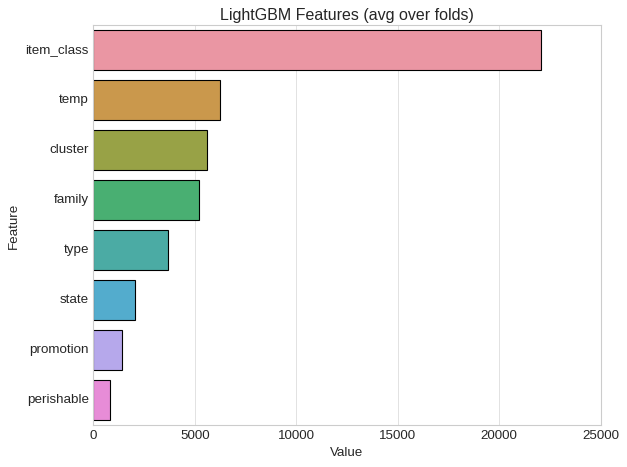

In [24]:

# feature importance graph
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('seaborn-whitegrid')
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

plotImp(bst,X_train)

In [25]:
# Save feature importance in a dataframe
pd.DataFrame(feature_importance_data, columns=['Step'] + list(X_train.columns)).to_csv('feature_importance.csv', index=None)

print("Validation LOG mse:", mean_squared_error(y_val, np.array(val_pred).transpose(), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))
print("Test LOG mse:", mean_squared_error(y_test, np.array(test_pred).transpose(), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))

print("Validation mse:", mean_squared_error(np.clip(np.expm1(y_val), 0, 1000), np.clip(np.expm1(np.array(val_pred).transpose()), 0, 1000), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))
print("Test mse:", mean_squared_error(np.clip(np.expm1(y_test), 0, 1000), np.clip(np.expm1(np.array(test_pred).transpose()), 0, 1000), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))

Validation LOG mse: 0.638039143942974
Test LOG mse: 0.6420420039587773
Validation mse: 135.167216491934
Test mse: 147.66461261703074


In [27]:
print("Combine with the test data split...")

df_preds_lg = pd.DataFrame(
    np.array(test_pred).transpose(), index=train_selected_sales.index,
    columns=pd.date_range("2017-07-31", periods=16)
).stack().to_frame("log_predicted_unit_sales")
df_preds_lg.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

df_test_lg = pd.DataFrame(
    y_test, index=train_selected_sales.index,
    columns=pd.date_range("2017-07-31", periods=16)
).stack().to_frame("log_actual_unit_sales")
df_test_lg.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)


comb_df = pd.concat([df_preds_lg, df_test_lg], axis=1)
comb_df['predicted_unit_sales'] = np.clip(np.expm1(comb_df["log_predicted_unit_sales"]), 0, 1000)
comb_df['actual_unit_sales'] = np.clip(np.expm1(comb_df["log_actual_unit_sales"]), 0, 1000)
# comb_df['perishable'] = df_items_2017["perishable"]

Combine with the test data split...


In [30]:
out_filename = 'drive/My Drive/favorita/model_outputs/' + 'lgbm_log_scaled_out_full.csv'
merge_df = pd.merge(comb_df.reset_index(), items_reindexed.reset_index(), on='item_nbr')
merge_df.to_csv(out_filename, index=None)

In [31]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14632384 entries, 0 to 14632383
Data columns (total 10 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   store_nbr                 int64         
 1   item_nbr                  int64         
 2   date                      datetime64[ns]
 3   log_predicted_unit_sales  float64       
 4   log_actual_unit_sales     float64       
 5   predicted_unit_sales      float64       
 6   actual_unit_sales         float64       
 7   family                    int64         
 8   class                     int64         
 9   perishable                int64         
dtypes: datetime64[ns](1), float64(4), int64(5)
memory usage: 1.2 GB


In [33]:
before_df = merge_df[merge_df.date < datetime(2017, 8, 7)]
after_df = merge_df[merge_df.date >= datetime(2017, 8, 7)]

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_error(weights, true_val, pred_val, predict_days_ahead=16):

    mse = mean_squared_error(true_val, pred_val, sample_weight=weights)
    rmse = np.sqrt(mse)

    mae = mean_absolute_error(true_val, pred_val, sample_weight=weights)

    mape = np.mean(np.abs((true_val - pred_val) / true_val)) * 100

    try:
        err = (true_val - pred_val) ** 2
        err = err.sum(axis=1) * weights
        nwrmsle = np.sqrt(err.sum() / weights.sum() / predict_days_ahead)
    except:
        nwrmsle = rmse

    return mse, rmse, nwrmsle, mae, mape

In [36]:
# errors for model
weights = merge_df["perishable"].values * 0.25 + 1
print('Unit', get_error(weights, merge_df['actual_unit_sales'].values, merge_df["predicted_unit_sales"].values))
print('Log', get_error(weights, merge_df['log_actual_unit_sales'].values, merge_df["log_predicted_unit_sales"].values))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Unit (147.6574459323012, 12.151438019111202, 12.151438019111202, 3.565603305191772, nan)
Log (0.6425664395933807, 0.8016024199023981, 0.8016024199023981, 0.6221523913554124, inf)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [37]:
# each store error grpah
store_results = merge_df.groupby(['date', 'store_nbr']).sum().reset_index()
store_results["diff"] = np.abs(store_results["actual_unit_sales"] - store_results["predicted_unit_sales"])
store_results.set_index("store_nbr",inplace=True)

2017-07-31T00:00:00.000000000
2017-08-01T00:00:00.000000000
2017-08-02T00:00:00.000000000
2017-08-03T00:00:00.000000000
2017-08-04T00:00:00.000000000
2017-08-05T00:00:00.000000000
2017-08-06T00:00:00.000000000
2017-08-07T00:00:00.000000000
2017-08-08T00:00:00.000000000
2017-08-09T00:00:00.000000000
2017-08-10T00:00:00.000000000
2017-08-11T00:00:00.000000000
2017-08-12T00:00:00.000000000
2017-08-13T00:00:00.000000000
2017-08-14T00:00:00.000000000
2017-08-15T00:00:00.000000000


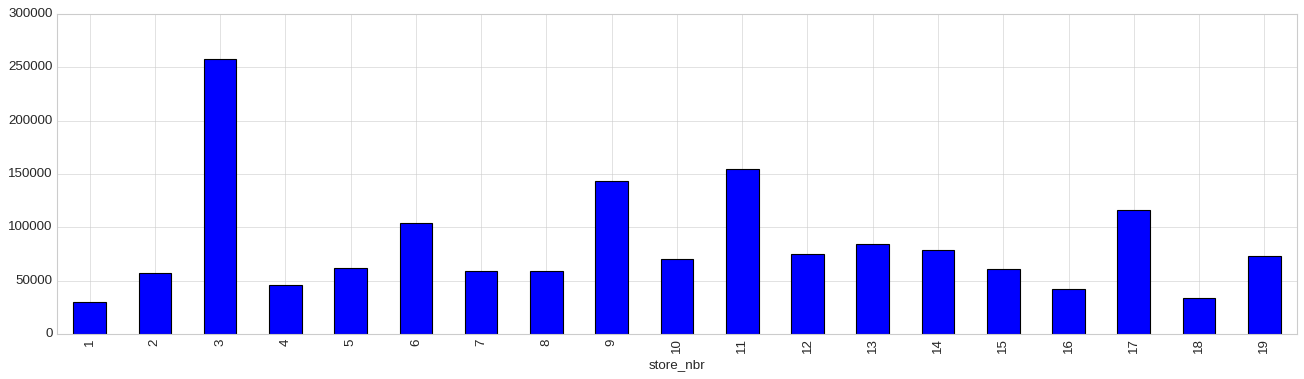

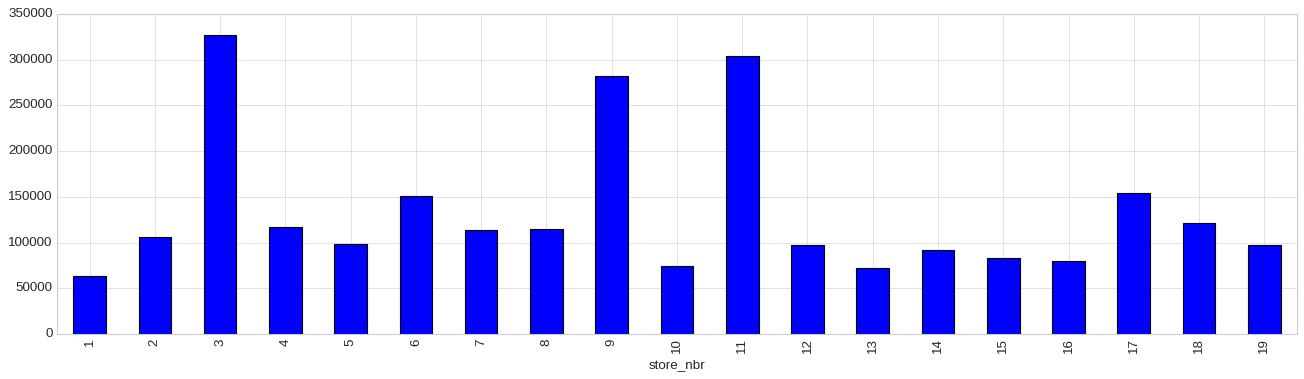

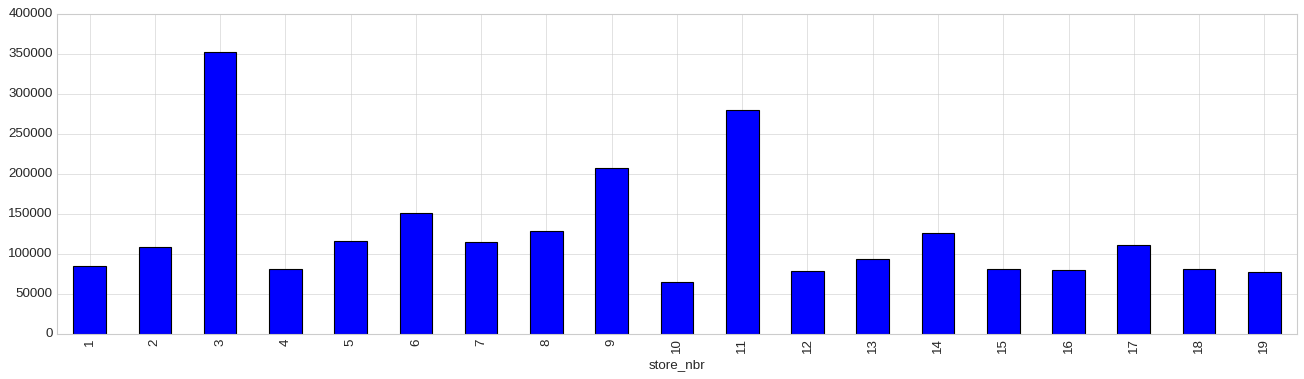

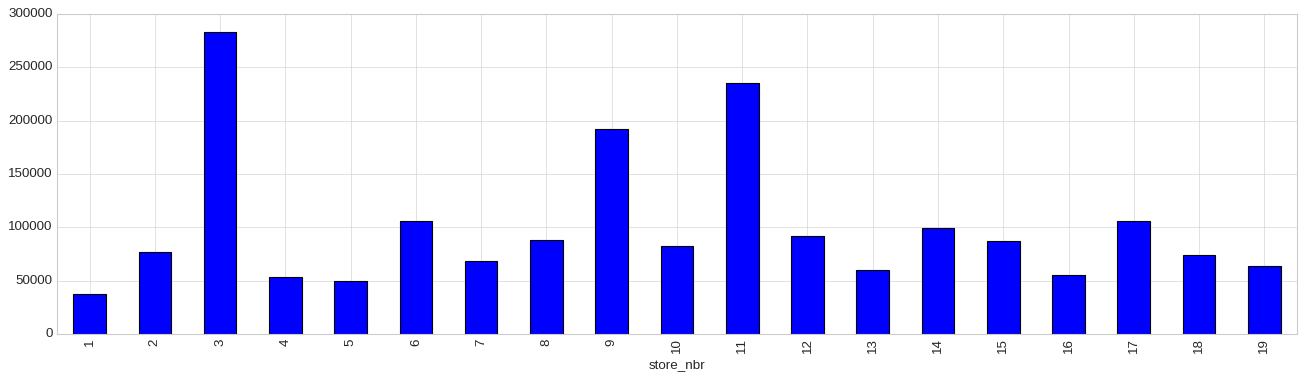

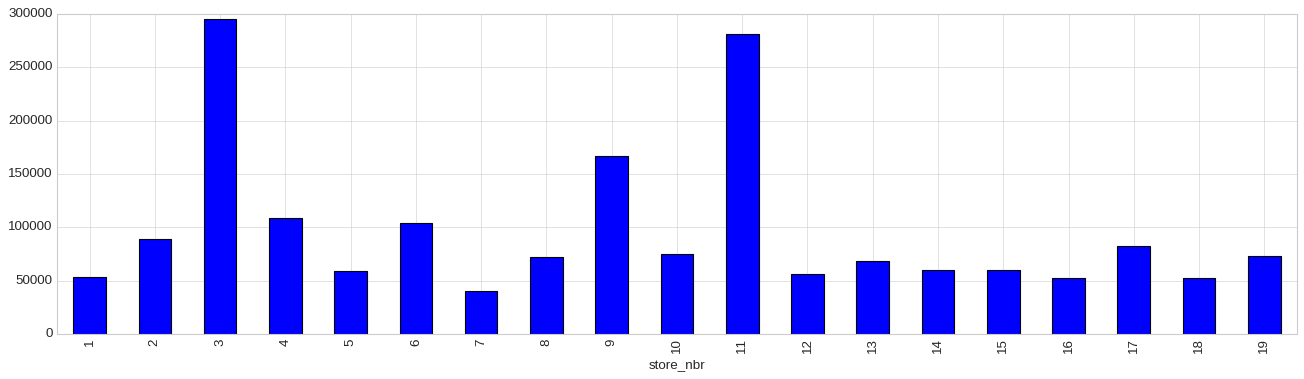

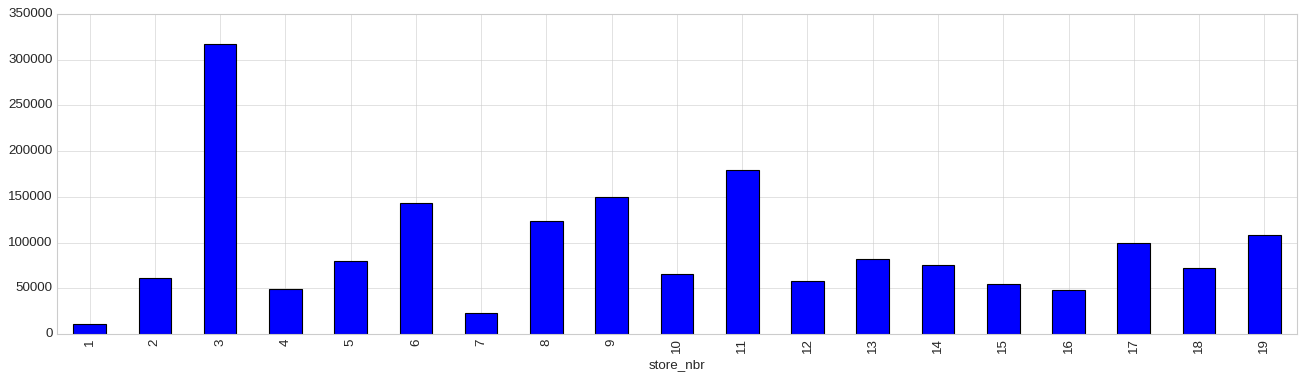

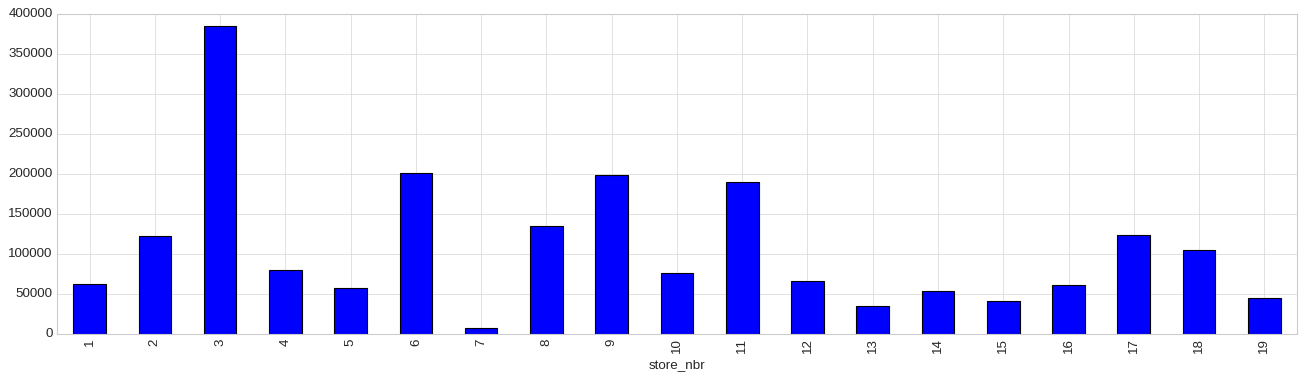

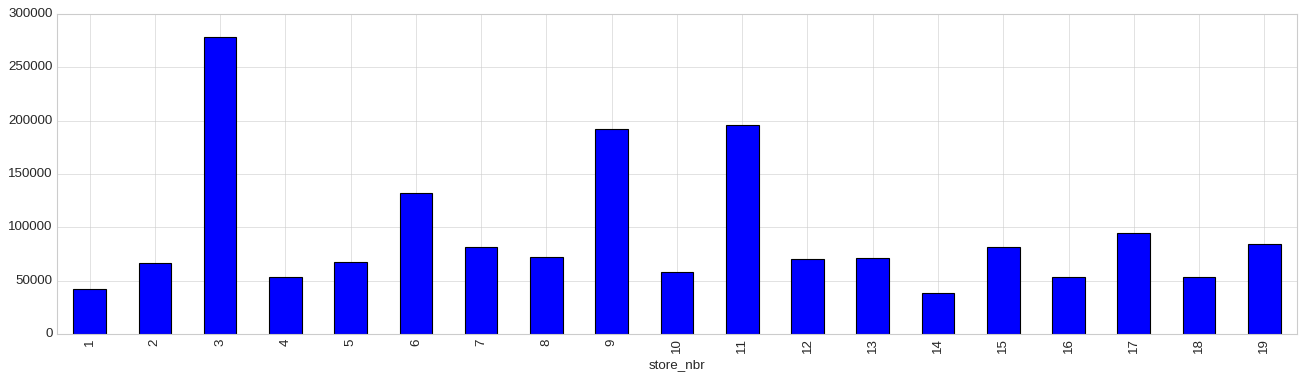

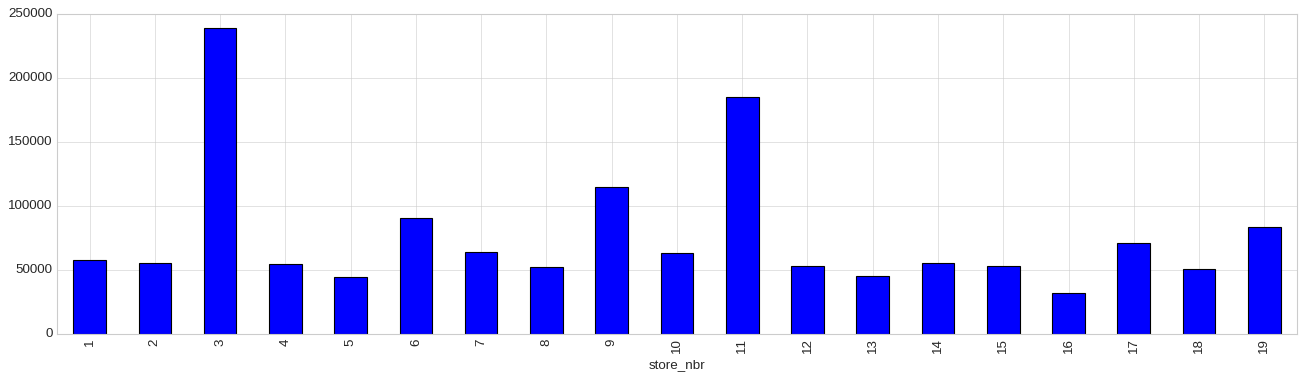

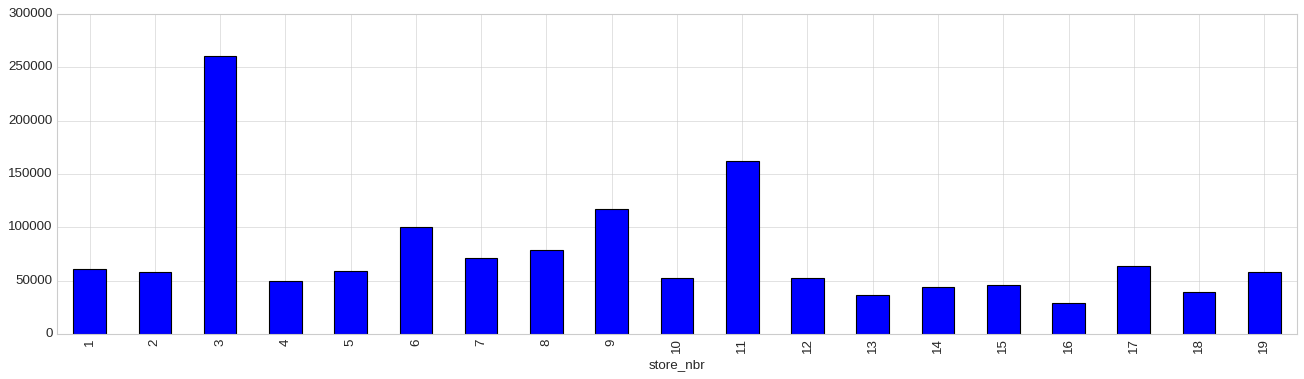

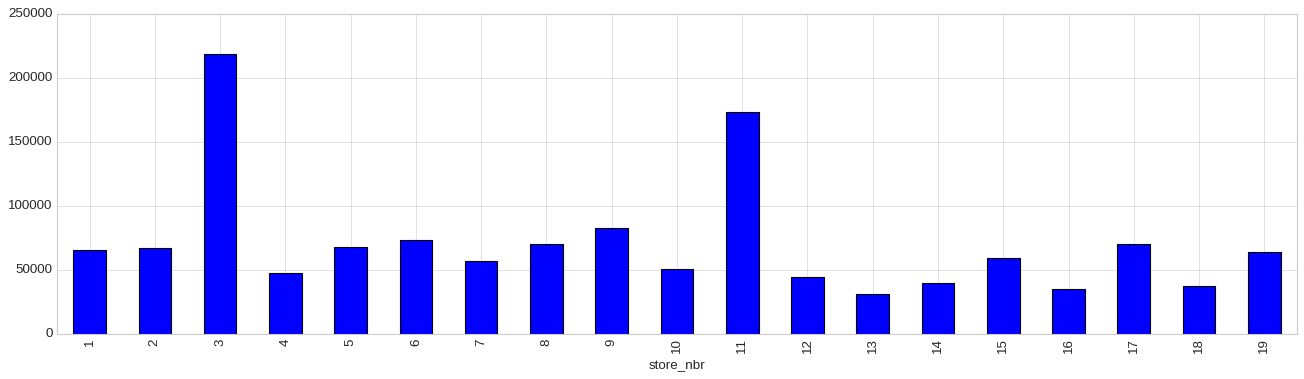

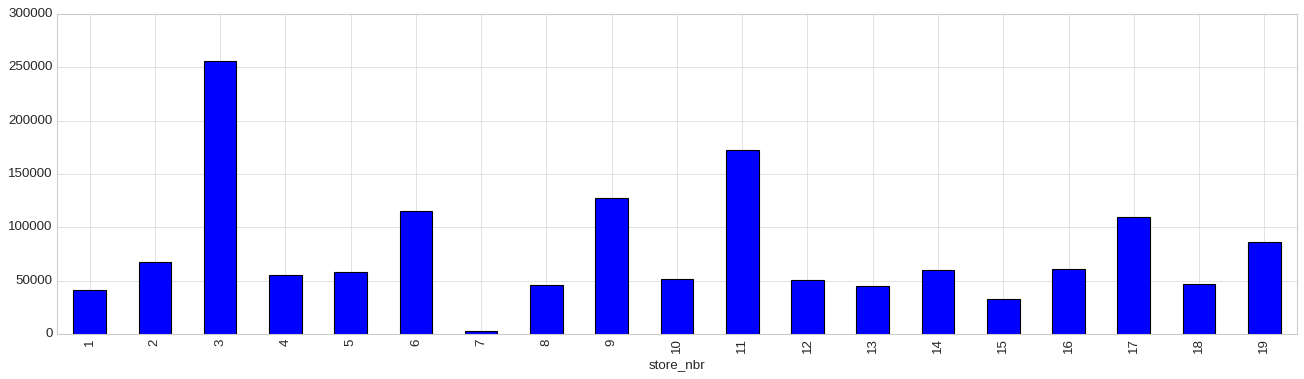

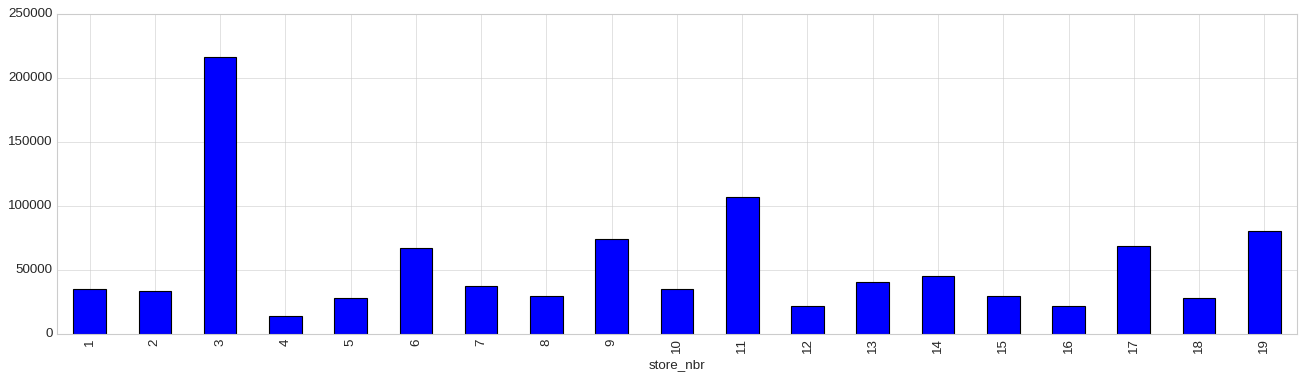

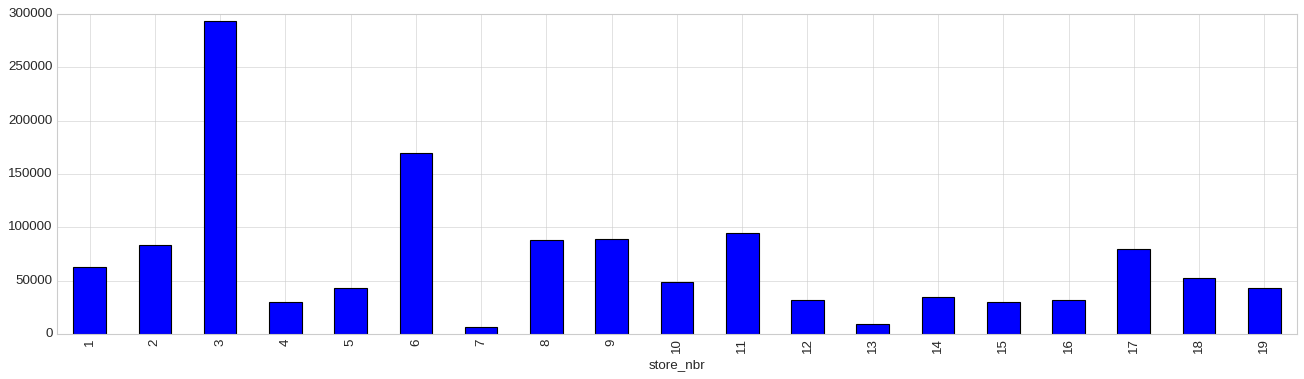

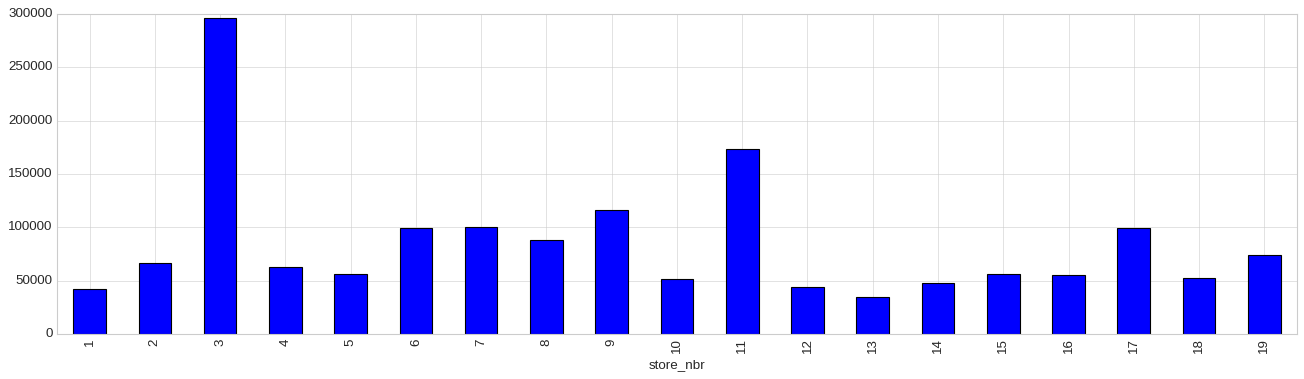

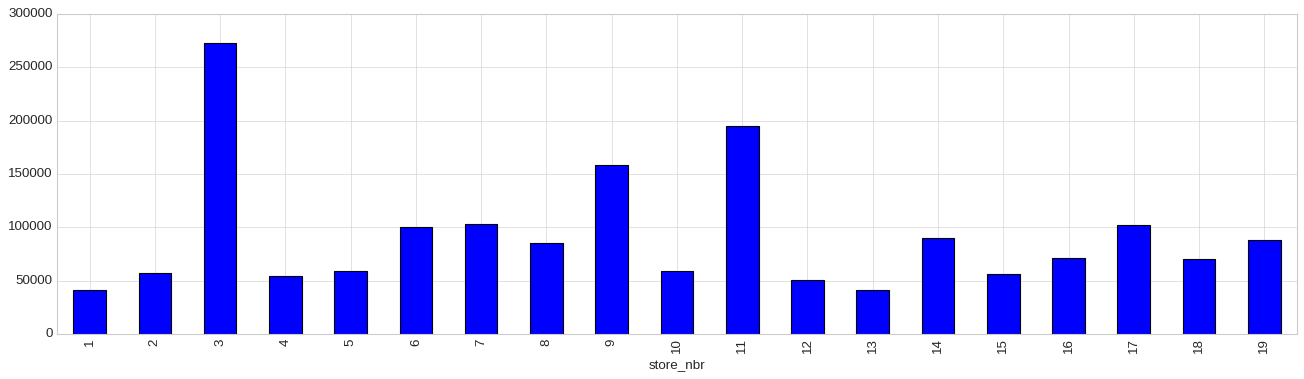

In [38]:
for i in store_results["date"].unique():
  print(i)
  plt.figure(figsize=(20, 5))
  store_results[store_results["date"] ==i]["diff"].plot.bar()

Explore high and low error stores

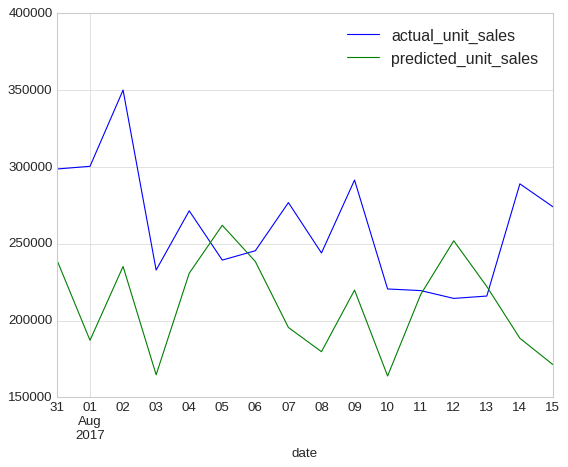

In [39]:
merge_df[merge_df["store_nbr"]==7][["date","actual_unit_sales","predicted_unit_sales"]].groupby("date").sum().plot()

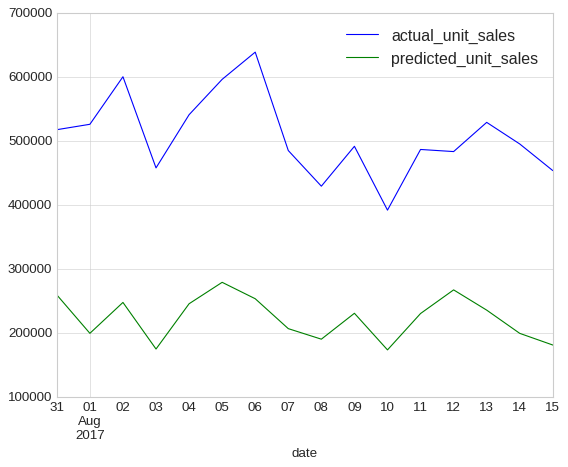

In [40]:
merge_df[merge_df["store_nbr"]==3][["date","actual_unit_sales","predicted_unit_sales"]].groupby("date").sum().plot()

class base errors for store 3

In [42]:
s_3_class = merge_df[merge_df["store_nbr"]==3][["class","date","actual_unit_sales","predicted_unit_sales"]].groupby(["date","class"]).sum().reset_index()

<Figure size 1600x400 with 0 Axes>

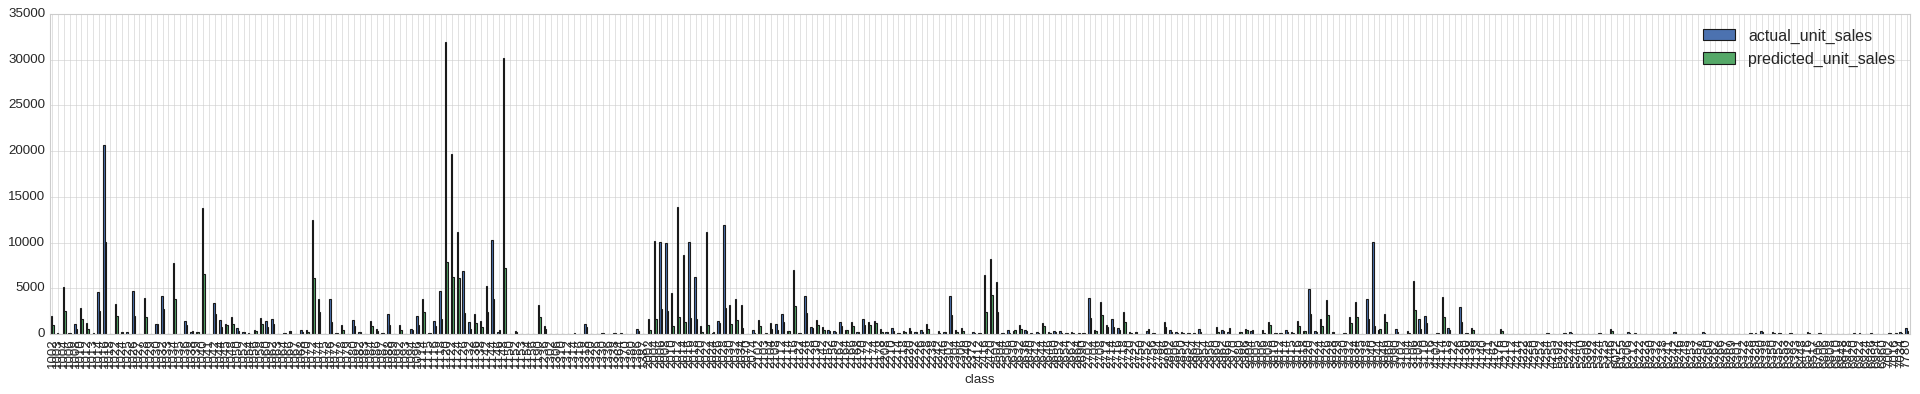

In [46]:
 plt.figure(figsize=(20, 5))
s_3_class[s_3_class["date"]=="2017-07-31"].plot.bar(x="class", y=["actual_unit_sales","predicted_unit_sales" ],figsize=(30, 5))

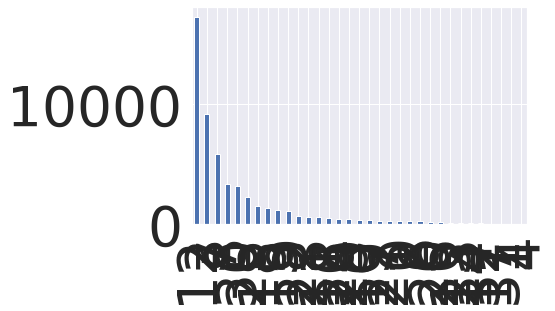

In [35]:
# family base error for single store
merge_df[(merge_df["store_nbr"]==7) & (merge_df["date"]=="2017-07-31")]["family"].value_counts().plot.bar()

In [ ]:
merge_df[(merge_df["store_nbr"]==3) & (merge_df["date"]=="2017-07-31")]["family"].value_counts()

12    17408
3      9110
7      5925
8      3362
30     3242
25     2293
18     1566
5      1411
15     1236
9      1122
22      702
28      638
16      594
11      589
24      444
29      405
10      349
19      317
27      309
21      295
0       263
2       245
6       233
20      217
26      187
13      139
23      113
14       74
32       73
31       40
17       19
1        16
4         8
Name: family, dtype: int64

## Model 2 (with engineered features)

In [61]:
print("Preparing dataset...1")

t2017 = date(2017, 5, 22)
X_l, y_l = [], []
for i in range(4):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset_1(t2017 + delta)
    X_l.append(X_tmp)
    y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset_1(date(2017, 7, 10))
X_test, y_test = prepare_dataset_1(date(2017, 7, 31))

Preparing dataset...1


In [44]:
print("Preparing dataset...1")

t2017 = date(2017, 5, 24)
X_l, y_l = [], []
for i in range(6):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset_1(t2017 + delta)
    X_l.append(X_tmp)
    y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset_1(date(2017, 7, 12))
X_test, y_test = prepare_dataset_1(date(2017, 7, 31))

Preparing dataset...1


In [62]:
params = {
    'num_leaves': 60,
    'objective': 'regression_l2',
    'max_depth': 10,
    'min_data_per_leaf': 300,
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.4,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4
}

In [64]:
MAX_ROUNDS = 1000
val_pred = []
test_pred = []
cate_vars = []
feature_importance_data = []

for i in range(16):

    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)

    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars,
        weight=pd.concat([items_reindexed["perishable"]]*4) * 0.25 + 1
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=items_reindexed["perishable"].values * 0.25 + 1,
        categorical_feature=cate_vars)
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=50
    )

    f_importance = ["Step {}".format(i)] + [fx for fx in bst.feature_importance("gain")]
    feature_importance_data.append(f_importance)

    val_pred.append(bst.predict(
        X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

    # Save model
    with open('lgb_step_{}.pickle'.format(i), 'wb') as file:
        pickle.dump(bst, file)


Step 1


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.340928	valid_1's l2: 0.3279
[100]	training's l2: 0.32737	valid_1's l2: 0.321103
[150]	training's l2: 0.322323	valid_1's l2: 0.320778
Early stopping, best iteration is:
[148]	training's l2: 0.322508	valid_1's l2: 0.320759
Step 2
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.348303	valid_1's l2: 0.341719
[100]	training's l2: 0.335752	valid_1's l2: 0.335106
[150]	training's l2: 0.331075	valid_1's l2: 0.334786
[200]	training's l2: 0.327494	valid_1's l2: 0.334797
Early stopping, best iteration is:
[153]	training's l2: 0.330799	valid_1's l2: 0.334732
Step 3
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.356745	valid_1's l2: 0.337737
[100]	training's l2: 0.34363	valid_1's l2: 0.333954
Early stopping, best iteration is:
[80]	training's l2: 0.346748	valid_1's l2: 0.333632
Step 4
Training until validation scores don't improve for 50 rounds

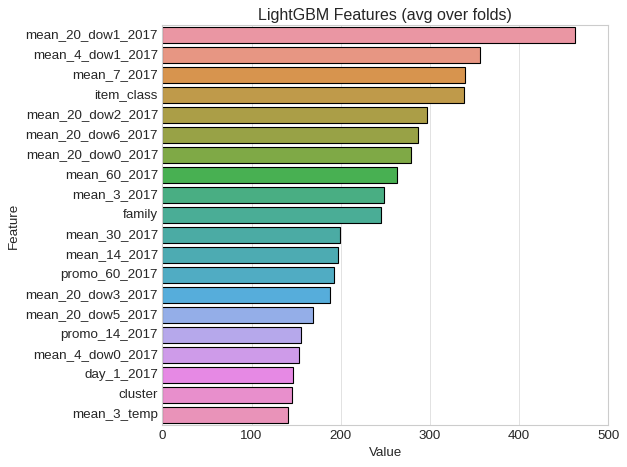

In [65]:
# feature importance graph
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('seaborn-whitegrid')
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    # plt.figure(figsize=fig_size)
    #sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

plotImp(bst,X_train)

In [66]:
# Save feature importance in a dataframe
pd.DataFrame(feature_importance_data, columns=['Step'] + list(X_train.columns)).to_csv('feature_importance.csv', index=None)

print("Validation LOG mse:", mean_squared_error(y_val, np.array(val_pred).transpose(), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))
print("Test LOG mse:", mean_squared_error(y_test, np.array(test_pred).transpose(), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))

print("Validation mse:", mean_squared_error(np.clip(np.expm1(y_val), 0, 1000), np.clip(np.expm1(np.array(val_pred).transpose()), 0, 1000), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))
print("Test mse:", mean_squared_error(np.clip(np.expm1(y_test), 0, 1000), np.clip(np.expm1(np.array(test_pred).transpose()), 0, 1000), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))

Validation LOG mse: 0.3743006492642616
Test LOG mse: 0.3775678516622676
Validation mse: 63.40379719078078
Test mse: 76.19798222123532


In [67]:
print("Combine with the test data split...")

df_preds_lg = pd.DataFrame(
    np.array(test_pred).transpose(), index=train_selected_sales.index,
    columns=pd.date_range("2017-07-31", periods=16)
).stack().to_frame("log_predicted_unit_sales")
df_preds_lg.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

df_test_lg = pd.DataFrame(
    y_test, index=train_selected_sales.index,
    columns=pd.date_range("2017-07-31", periods=16)
).stack().to_frame("log_actual_unit_sales")
df_test_lg.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)


comb_df = pd.concat([df_preds_lg, df_test_lg], axis=1)
comb_df['predicted_unit_sales'] = np.clip(np.expm1(comb_df["log_predicted_unit_sales"]), 0, 1000)
comb_df['actual_unit_sales'] = np.clip(np.expm1(comb_df["log_actual_unit_sales"]), 0, 1000)
# comb_df['perishable'] = df_items_2017["perishable"]

Combine with the test data split...


In [68]:
# save data to file
out_filename = 'drive/My Drive/favorita/model_outputs/' + 'lgbm_log_scaled_out_fe_model.csv'
merge_df = pd.merge(comb_df.reset_index(), items_reindexed.reset_index(), on='item_nbr')
merge_df.to_csv(out_filename, index=None)

In [ ]:
merge_df.date.min(), merge_df.date.max()

(Timestamp('2017-07-31 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_error(weights, true_val, pred_val, predict_days_ahead=16):

    mse = mean_squared_error(true_val, pred_val, sample_weight=weights)
    rmse = np.sqrt(mse)

    mae = mean_absolute_error(true_val, pred_val, sample_weight=weights)

    mape = np.mean(np.abs((true_val - pred_val) / true_val)) * 100

    try:
        err = (true_val - pred_val) ** 2
        err = err.sum(axis=1) * weights
        nwrmsle = np.sqrt(err.sum() / weights.sum() / predict_days_ahead)
    except:
        nwrmsle = rmse

    return mse, rmse, nwrmsle, mae, mape

In [71]:
weights = merge_df["perishable"].values * 0.25 + 1
print('Unit', get_error(weights, merge_df['actual_unit_sales'].values, merge_df["predicted_unit_sales"].values))
print('Log', get_error(weights, merge_df['log_actual_unit_sales'].values, merge_df["log_predicted_unit_sales"].values))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Unit (77.23395523638226, 8.78828511351232, 8.78828511351232, 2.457312834388106, nan)
Log (0.3821834617867108, 0.6182098848988997, 0.6182098848988997, 0.46540298552483256, inf)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [50]:
# load previous model predictions (no need to run if running the model)
merge_df = pd.read_csv("drive/MyDrive/favorita/model_outputs/nn_log_scaled_out_fe_model.csv")

In [72]:
# each store error analysis
store_results = merge_df.groupby(['date', 'store_nbr']).sum().reset_index()
store_results["diff"] = np.abs(store_results["actual_unit_sales"] - store_results["predicted_unit_sales"])
store_results.set_index("store_nbr",inplace=True)

2017-07-31T00:00:00.000000000
2017-08-01T00:00:00.000000000
2017-08-02T00:00:00.000000000
2017-08-03T00:00:00.000000000
2017-08-04T00:00:00.000000000
2017-08-05T00:00:00.000000000
2017-08-06T00:00:00.000000000
2017-08-07T00:00:00.000000000
2017-08-08T00:00:00.000000000
2017-08-09T00:00:00.000000000
2017-08-10T00:00:00.000000000
2017-08-11T00:00:00.000000000
2017-08-12T00:00:00.000000000
2017-08-13T00:00:00.000000000
2017-08-14T00:00:00.000000000
2017-08-15T00:00:00.000000000


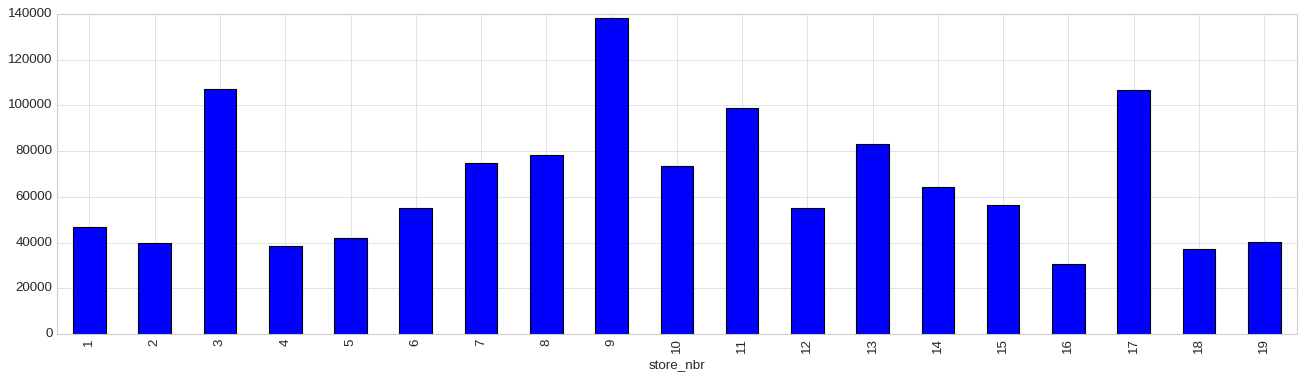

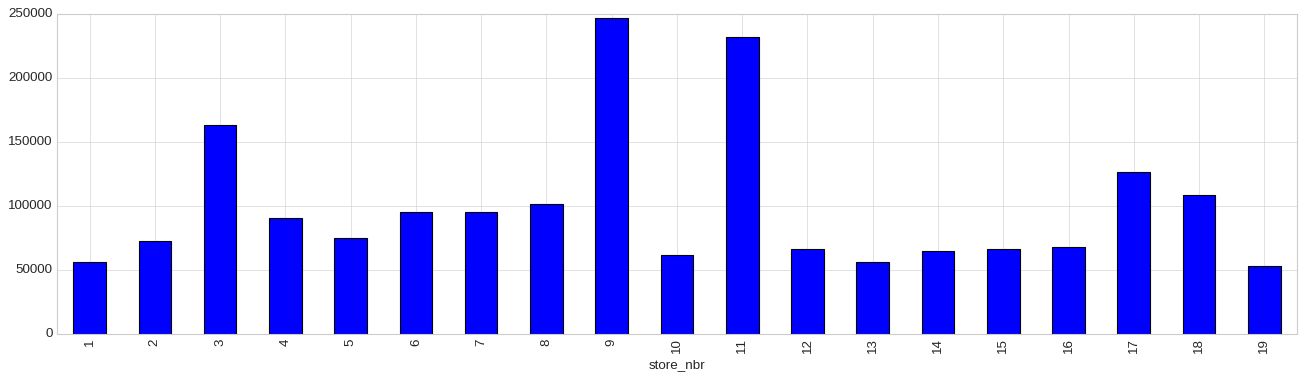

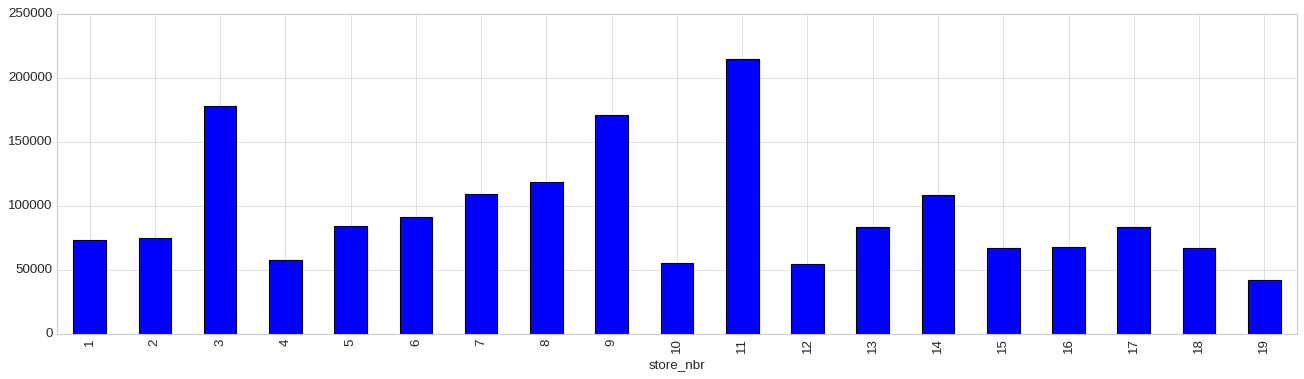

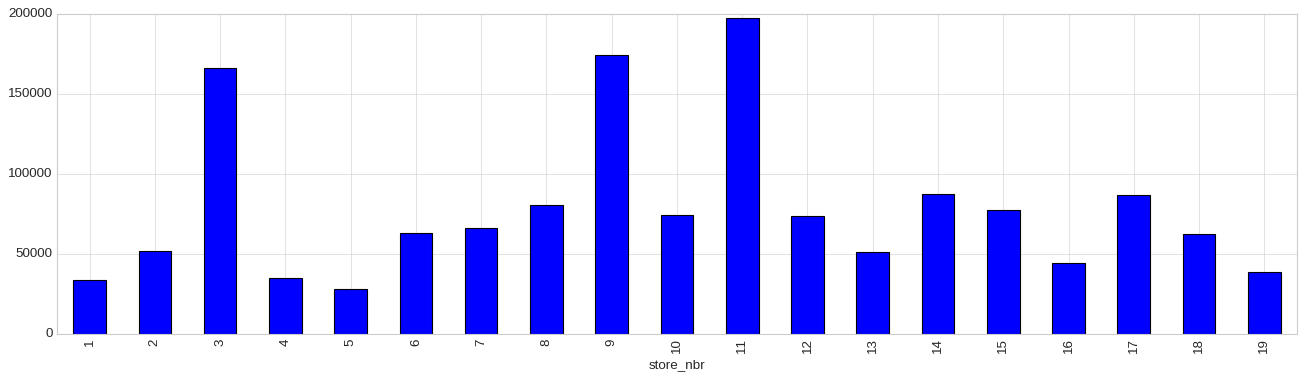

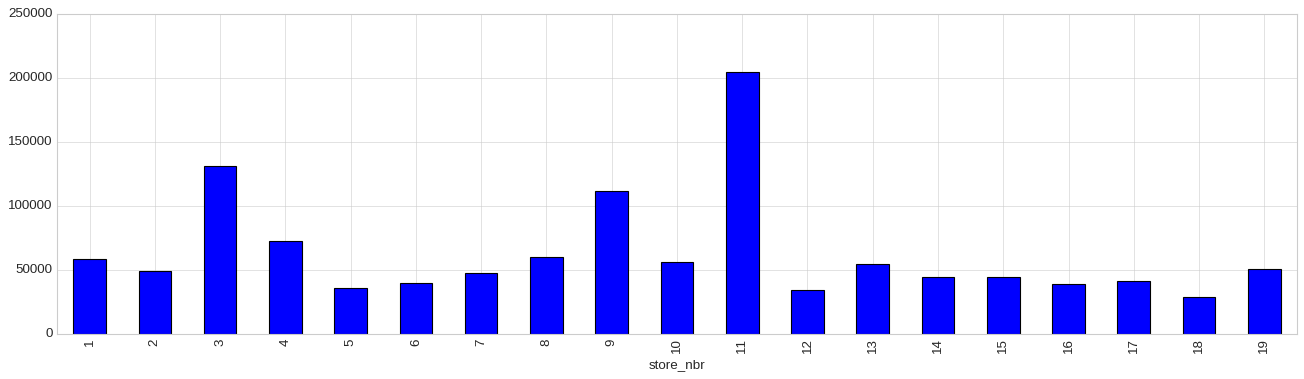

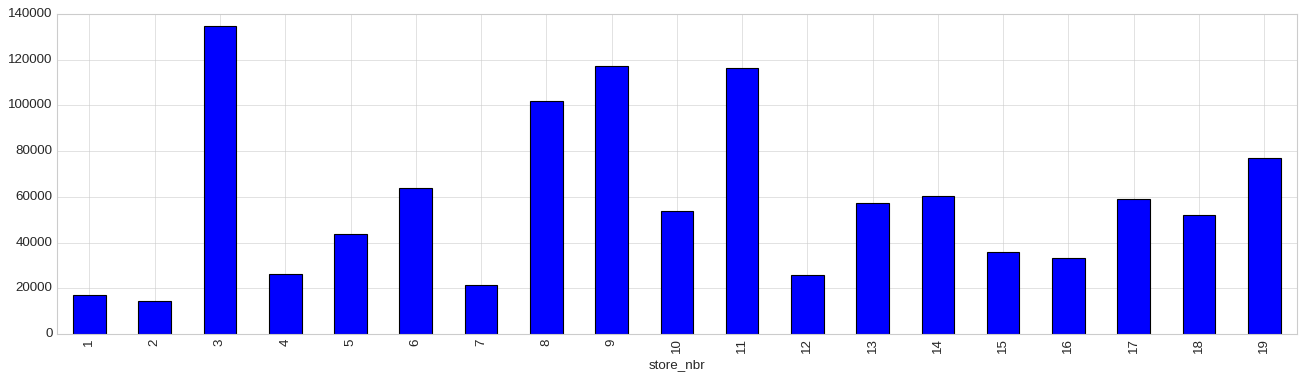

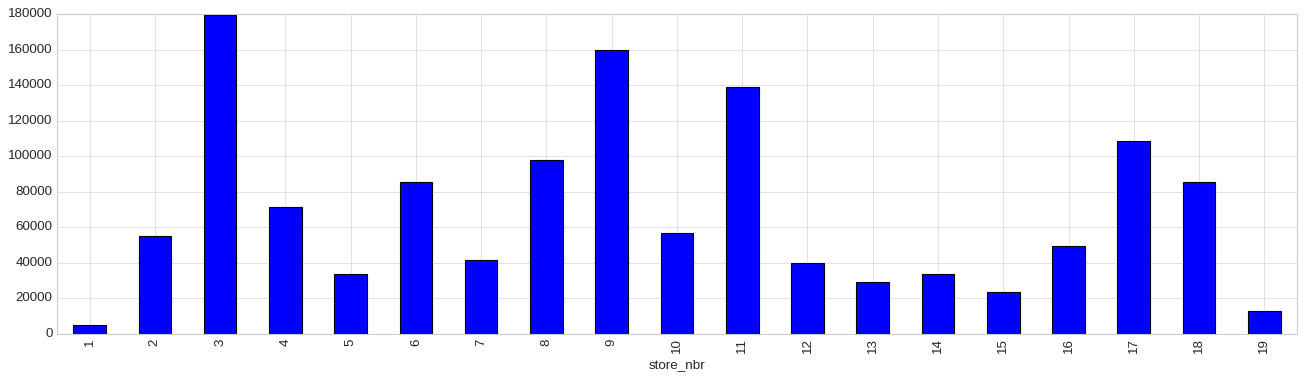

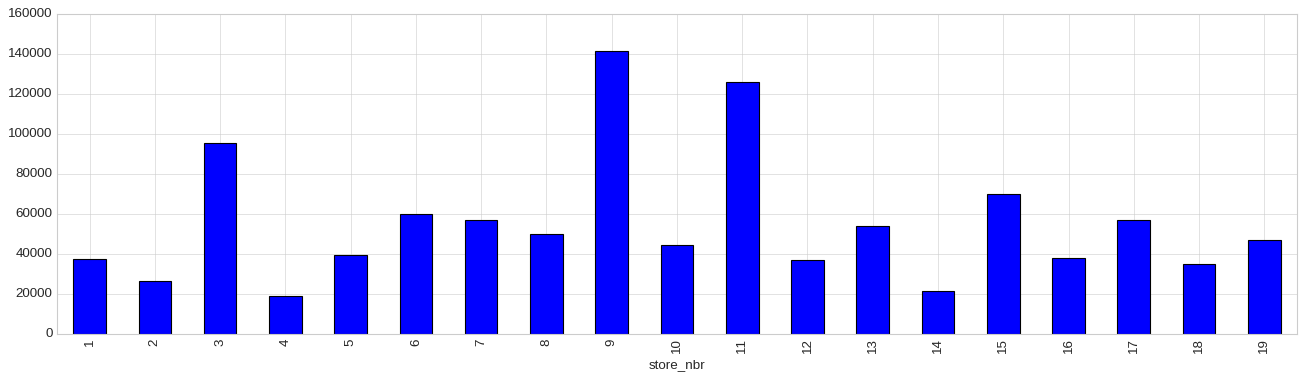

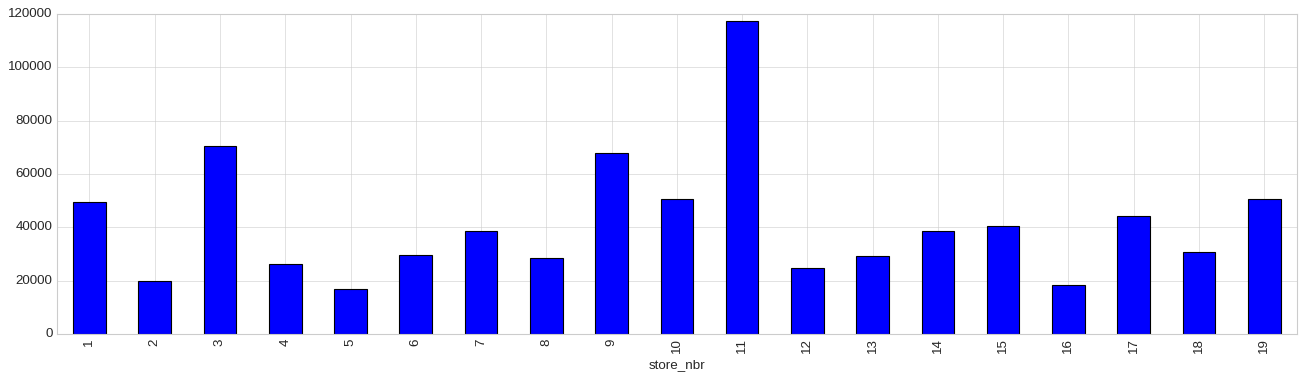

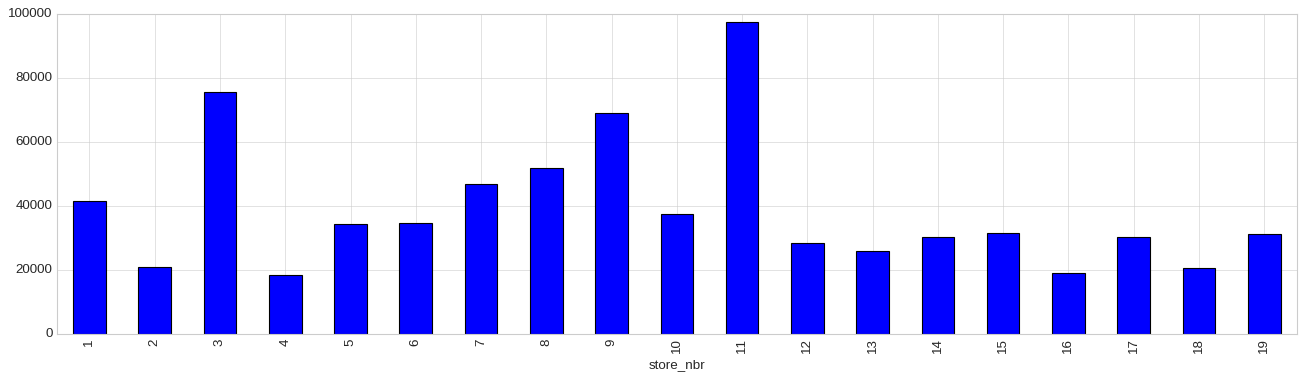

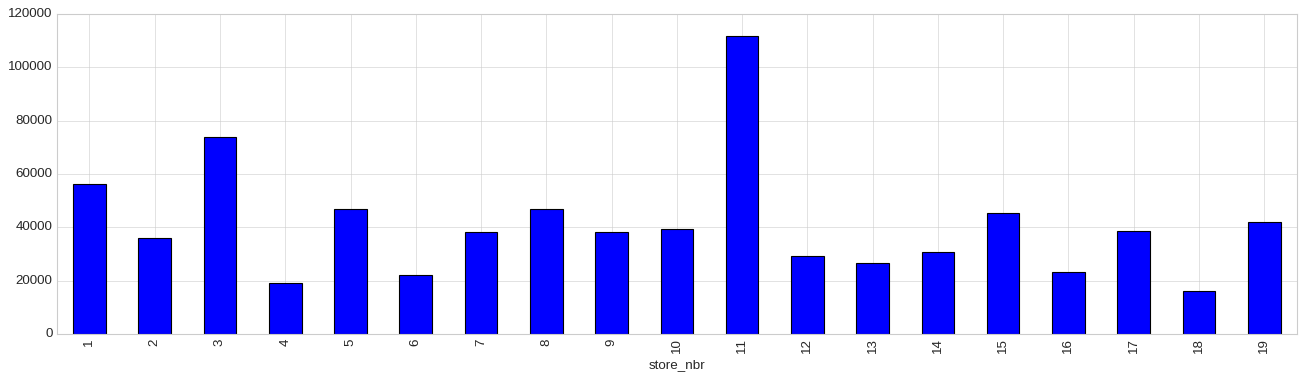

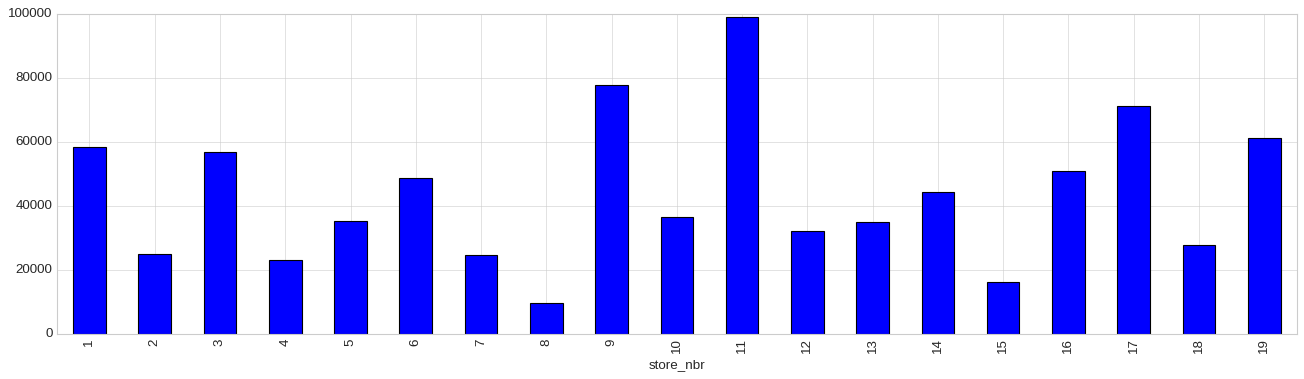

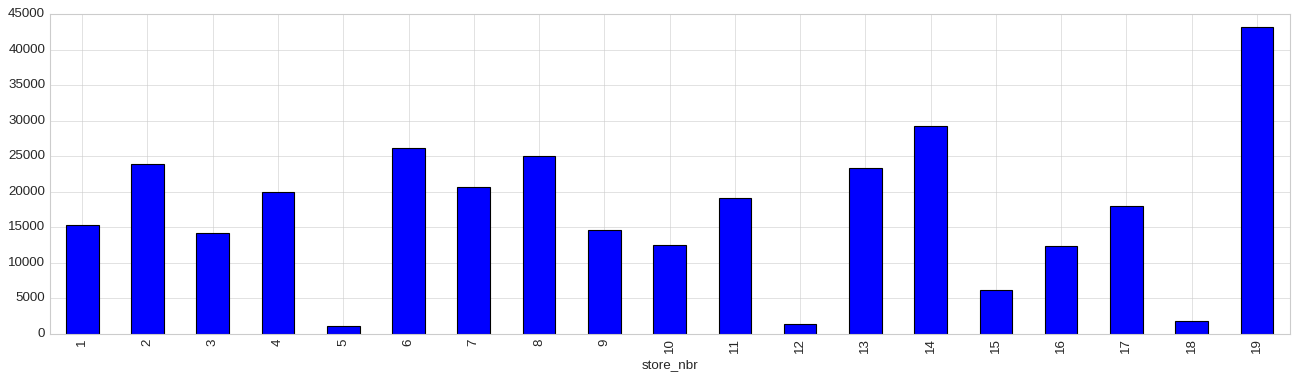

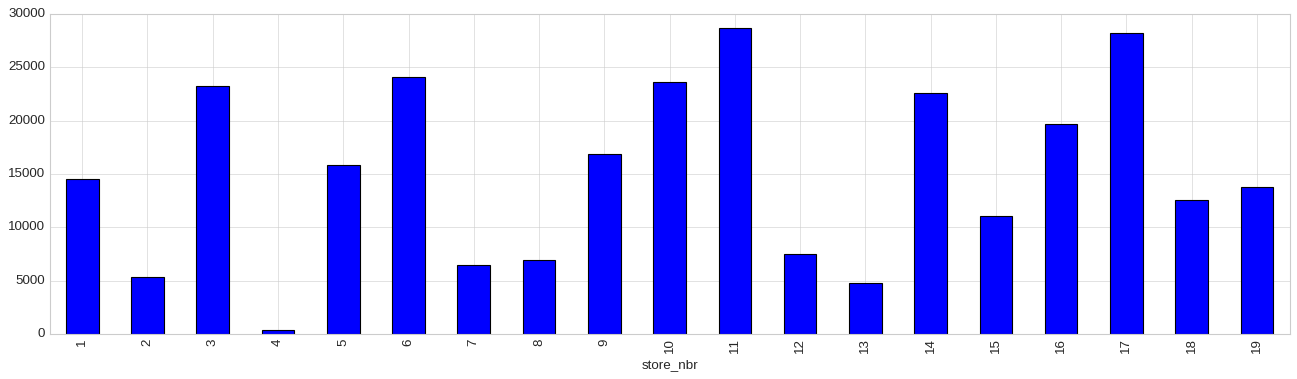

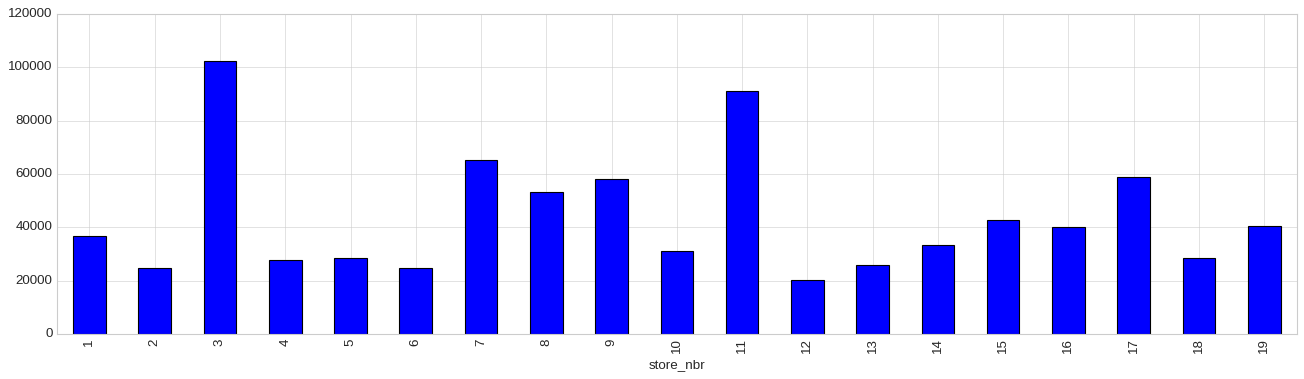

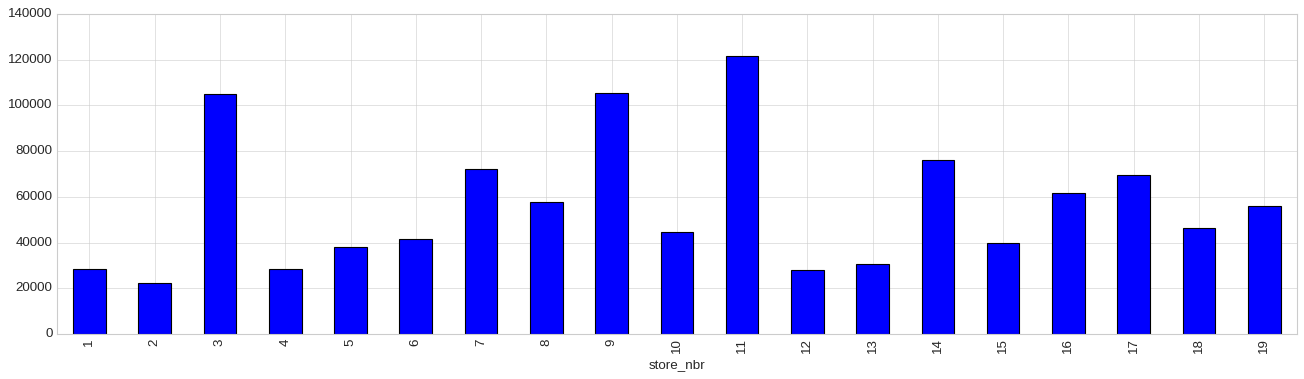

In [73]:
for i in store_results["date"].unique():
  print(i)
  plt.figure(figsize=(20, 5))
  store_results[store_results["date"] ==i]["diff"].plot.bar()

High and low error store analysis

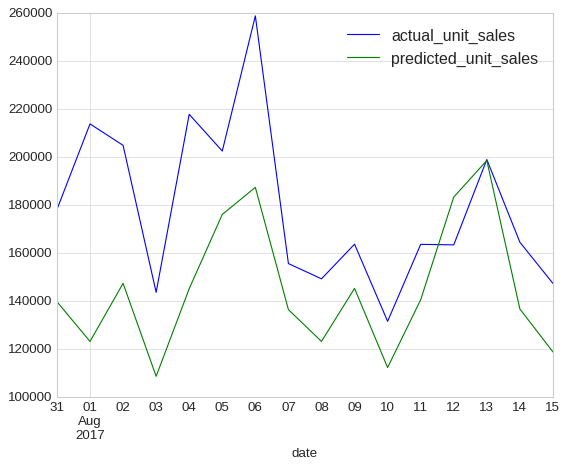

In [76]:
merge_df[merge_df["store_nbr"]==4][["date","actual_unit_sales","predicted_unit_sales"]].groupby("date").sum().plot()

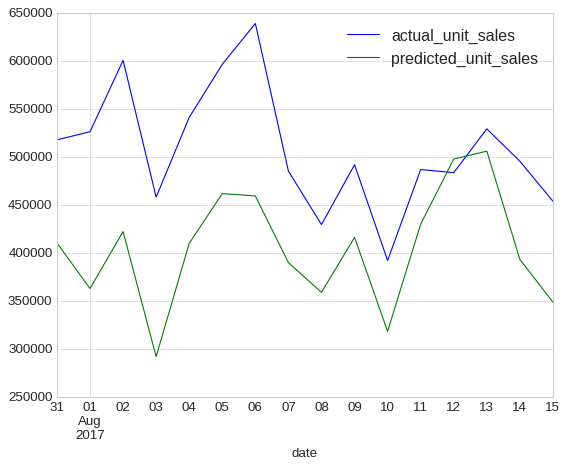

In [75]:
merge_df[merge_df["store_nbr"]==3][["date","actual_unit_sales","predicted_unit_sales"]].groupby("date").sum().plot()

error by class for each store

In [ ]:
s_3_class = merge_df[merge_df["store_nbr"]==3][["class","date","actual_unit_sales","predicted_unit_sales"]].groupby(["date","class"]).sum().reset_index()

<Figure size 1600x400 with 0 Axes>

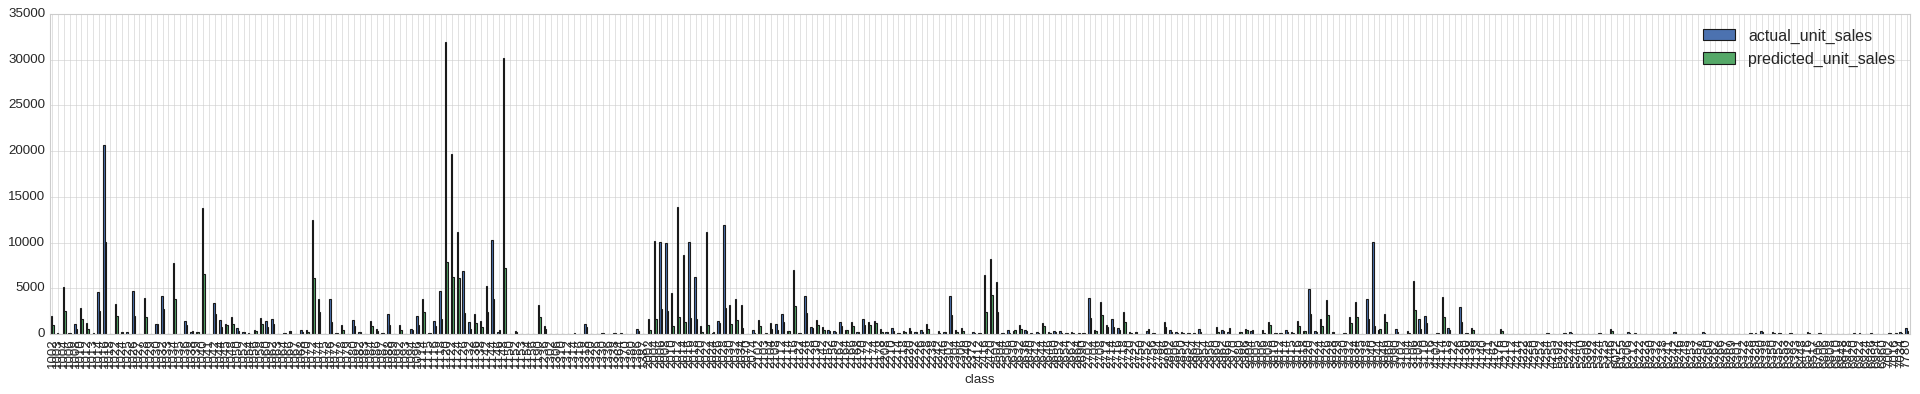

In [ ]:
 plt.figure(figsize=(20, 5))
s_3_class[s_3_class["date"]=="2017-07-31"].plot.bar(x="class", y=["actual_unit_sales","predicted_unit_sales" ],figsize=(30, 5))

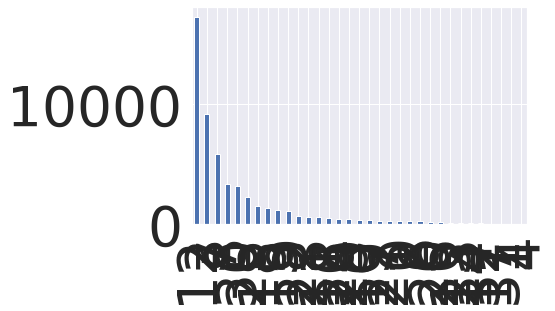

In [ ]:
# error by family for each store
merge_df[(merge_df["store_nbr"]==7) & (merge_df["date"]=="2017-07-31")]["family"].value_counts().plot.bar()

In [ ]:
merge_df[(merge_df["store_nbr"]==3) & (merge_df["date"]=="2017-07-31")]["family"].value_counts()

12    17408
3      9110
7      5925
8      3362
30     3242
25     2293
18     1566
5      1411
15     1236
9      1122
22      702
28      638
16      594
11      589
24      444
29      405
10      349
19      317
27      309
21      295
0       263
2       245
6       233
20      217
26      187
13      139
23      113
14       74
32       73
31       40
17       19
1        16
4         8
Name: family, dtype: int64

## Model 3 NN (engineered features)

In [77]:
print("Preparing dataset...1")

t2017 = date(2017, 5, 22)
X_l, y_l = [], []
for i in range(4):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset_1(t2017 + delta)
    X_l.append(X_tmp)
    y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset_1(date(2017, 7, 12))
X_test, y_test = prepare_dataset_1(date(2017, 7, 31))

Preparing dataset...1


In [78]:
# transform the data for NN model
scaler = StandardScaler()
scaler.fit(pd.concat([X_train, X_val, X_test]))
X_train[:] = scaler.transform(X_train)
X_val[:] = scaler.transform(X_val)
X_test[:] = scaler.transform(X_test)

X_train = X_train.values
X_test = X_test.values
X_val = X_val.values
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [79]:
def build_model():

    model = Sequential()

    model.add(LSTM(32, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(.1))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))

    model.add(Dense(1))

    return model

In [82]:
N_EPOCHS = 1000

val_pred = []
test_pred = []

sample_weights = np.array(pd.concat([items_reindexed["perishable"]] * 4) * 0.25 + 1)
for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)

    y = y_train[:, i]
    y_mean = y.mean()
    xv = X_val
    yv = y_val[:, i]

    model = build_model()
    opt = optimizers.Adam(lr=0.001)
    model.compile(loss='mse', optimizer=opt, metrics=['mse'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
        ]

    model.fit(X_train, y - y_mean, batch_size = 65536, epochs = N_EPOCHS, verbose=2,
               sample_weight=sample_weights, validation_data=(xv,yv-y_mean), callbacks=callbacks )
    
    val_pred.append(model.predict(X_val)+y_mean)
    test_pred.append(model.predict(X_test)+y_mean)

Step 1


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
4/4 - 1s - loss: 0.4329 - mse: 0.4101 - val_loss: 0.3848 - val_mse: 0.3848 - lr: 0.0010 - 717ms/epoch - 179ms/step
Epoch 201/1000
4/4 - 1s - loss: 0.4335 - mse: 0.4106 - val_loss: 0.3848 - val_mse: 0.3848 - lr: 0.0010 - 744ms/epoch - 186ms/step
Epoch 202/1000
4/4 - 1s - loss: 0.4319 - mse: 0.4091 - val_loss: 0.3848 - val_mse: 0.3848 - lr: 0.0010 - 703ms/epoch - 176ms/step
Epoch 203/1000
4/4 - 1s - loss: 0.4315 - mse: 0.4088 - val_loss: 0.3847 - val_mse: 0.3847 - lr: 0.0010 - 703ms/epoch - 176ms/step
Epoch 204/1000
4/4 - 1s - loss: 0.4319 - mse: 0.4090 - val_loss: 0.3847 - val_mse: 0.3847 - lr: 0.0010 - 700ms/epoch - 175ms/step
Epoch 205/1000
4/4 - 1s - loss: 0.4324 - mse: 0.4097 - val_loss: 0.3846 - val_mse: 0.3846 - lr: 0.0010 - 728ms/epoch - 182ms/step
Epoch 206/1000
4/4 - 1s - loss: 0.4307 - mse: 0.4080 - val_loss: 0.3844 - val_mse: 0.3844 - lr: 0.0010 - 921ms/epoch - 230ms/step
Epoch 207/1000
4/4 - 1s - loss: 0.4303 - mse: 0.4076 -

In [83]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 32)                8192      
                                                                 
 batch_normalization_32 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_32 (Dropout)        (None, 32)                0         
                                                                 
 dense_32 (Dense)            (None, 32)                1056      
                                                                 
 batch_normalization_33 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_33 (Dropout)        (None, 32)              

In [84]:
weight = items_reindexed["perishable"] * 0.25 + 1
err = (y_val - np.array(val_pred).transpose()[0])**2
err = err.sum(axis=1) * weight
err = np.sqrt(err.sum() / weight.sum() / 16)
print('nwrmsle = {}'.format(err))

nwrmsle = 0.705986050234267


In [85]:
print("Validation mse:", mean_squared_error(np.clip(np.expm1(y_val), 0, 1000), np.clip(np.expm1(np.array(val_pred).transpose()[0]), 0, 1000), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))
print("Test mse:", mean_squared_error(np.clip(np.expm1(y_test), 0, 1000), np.clip(np.expm1(np.array(test_pred).transpose()[0]), 0, 1000), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))

Validation mse: 87.39712853228625
Test mse: 99.47092228229766


In [86]:
print("Combine with the test data split...")

df_preds_lg = pd.DataFrame(
    np.array(test_pred).transpose()[0], index=train_selected_sales.index,
    columns=pd.date_range("2017-07-31", periods=16)
).stack().to_frame("log_predicted_unit_sales")
df_preds_lg.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

df_test_lg = pd.DataFrame(
    y_test, index=train_selected_sales.index,
    columns=pd.date_range("2017-07-31", periods=16)
).stack().to_frame("log_actual_unit_sales")
df_test_lg.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)


comb_df = pd.concat([df_preds_lg, df_test_lg], axis=1)
comb_df['predicted_unit_sales'] = np.clip(np.expm1(comb_df["log_predicted_unit_sales"]), 0, 1000)
comb_df['actual_unit_sales'] = np.clip(np.expm1(comb_df["log_actual_unit_sales"]), 0, 1000)
# comb_df['perishable'] = df_items_2017["perishable"]

Combine with the test data split...


In [87]:
# store the model prediction
out_filename = 'drive/My Drive/favorita/model_outputs/' + 'nn_log_scaled_out_fe_model.csv'
merge_df = pd.merge(comb_df.reset_index(), items_reindexed.reset_index(), on='item_nbr')
merge_df.to_csv(out_filename, index=None)

In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_error(weights, true_val, pred_val, predict_days_ahead=16):

    mse = mean_squared_error(true_val, pred_val, sample_weight=weights)
    rmse = np.sqrt(mse)

    mae = mean_absolute_error(true_val, pred_val, sample_weight=weights)

    mape = np.mean(np.abs((true_val - pred_val) / true_val)) * 100

    try:
        err = (true_val - pred_val) ** 2
        err = err.sum(axis=1) * weights
        nwrmsle = np.sqrt(err.sum() / weights.sum() / predict_days_ahead)
    except:
        nwrmsle = rmse

    return mse, rmse, nwrmsle, mae, mape

In [90]:
weights = merge_df["perishable"].values * 0.25 + 1
print('Unit', get_error(weights, merge_df['actual_unit_sales'].values, merge_df["predicted_unit_sales"].values))
print('Log', get_error(weights, merge_df['log_actual_unit_sales'].values, merge_df["log_predicted_unit_sales"].values))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Unit (100.57598627250005, 10.028757962604345, 10.028757962604345, 2.8396459259579396, nan)
Log (0.4946678880566987, 0.7033263026907913, 0.7033263026907913, 0.5363003988762325, inf)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [98]:
store_results = merge_df.groupby(['date', 'store_nbr']).sum().reset_index()
store_results["diff"] = np.abs(store_results["actual_unit_sales"] - store_results["predicted_unit_sales"])
store_results.set_index("store_nbr",inplace=True)

2017-07-31T00:00:00.000000000
2017-08-01T00:00:00.000000000
2017-08-02T00:00:00.000000000
2017-08-03T00:00:00.000000000
2017-08-04T00:00:00.000000000
2017-08-05T00:00:00.000000000
2017-08-06T00:00:00.000000000
2017-08-07T00:00:00.000000000
2017-08-08T00:00:00.000000000
2017-08-09T00:00:00.000000000
2017-08-10T00:00:00.000000000
2017-08-11T00:00:00.000000000
2017-08-12T00:00:00.000000000
2017-08-13T00:00:00.000000000
2017-08-14T00:00:00.000000000
2017-08-15T00:00:00.000000000


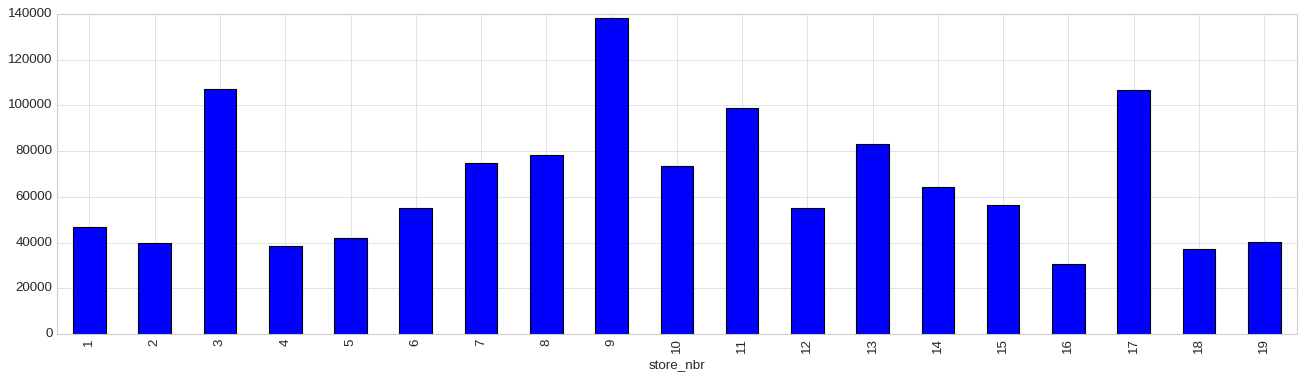

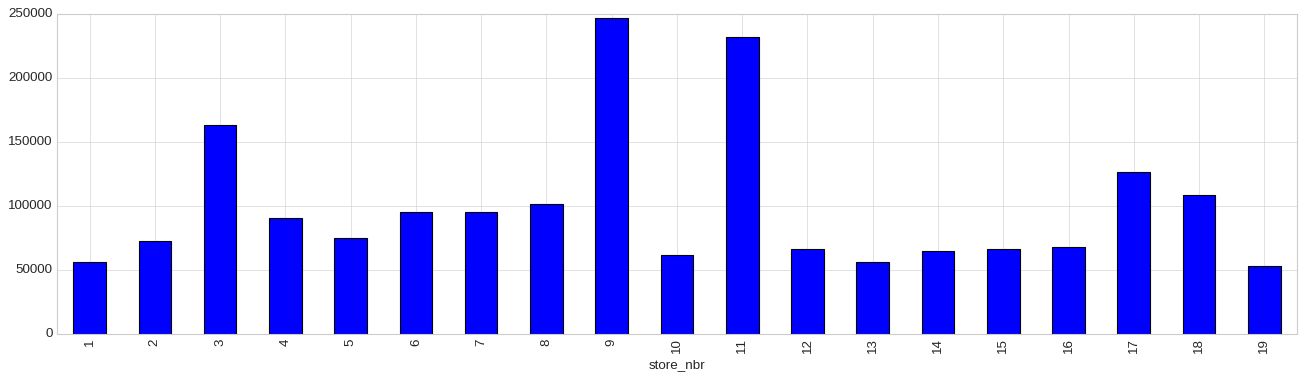

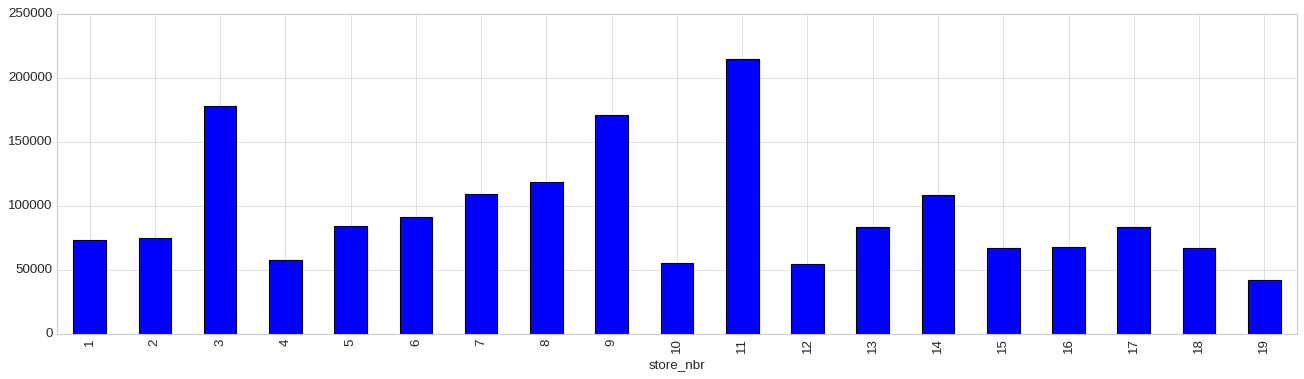

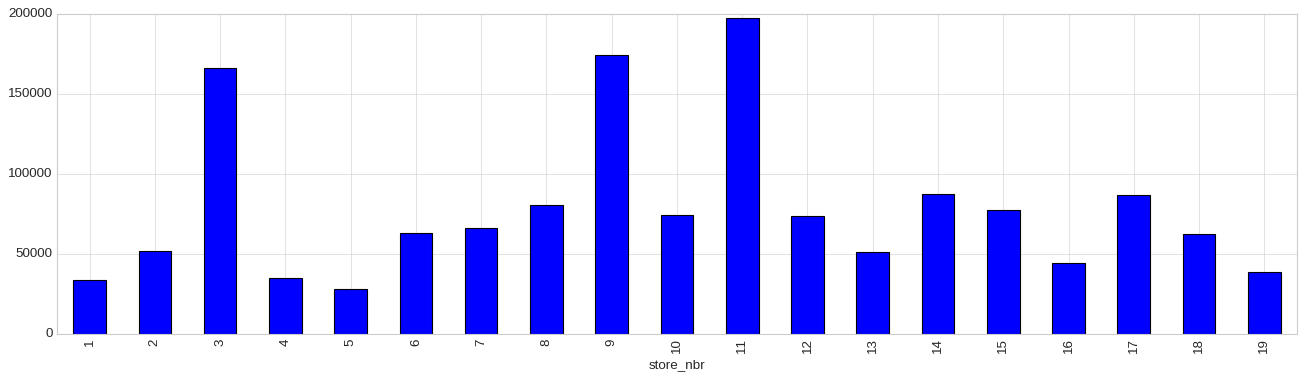

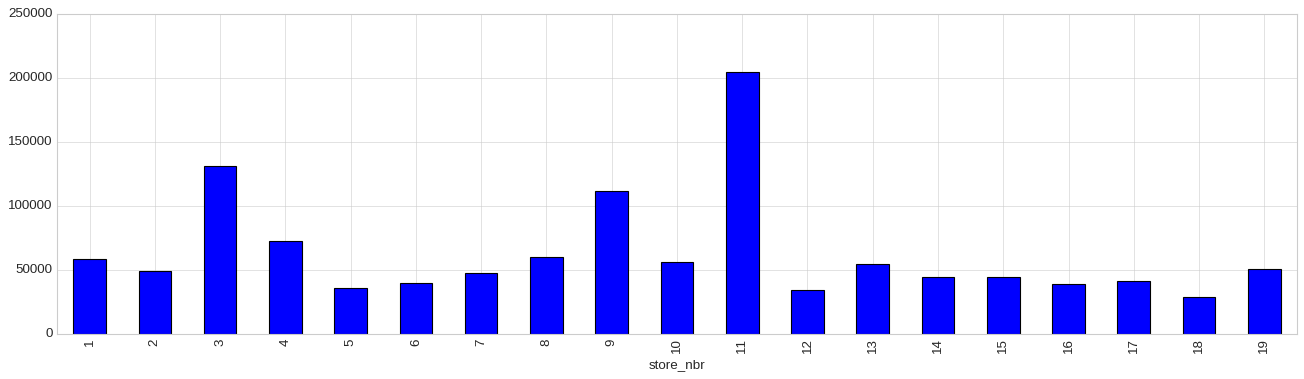

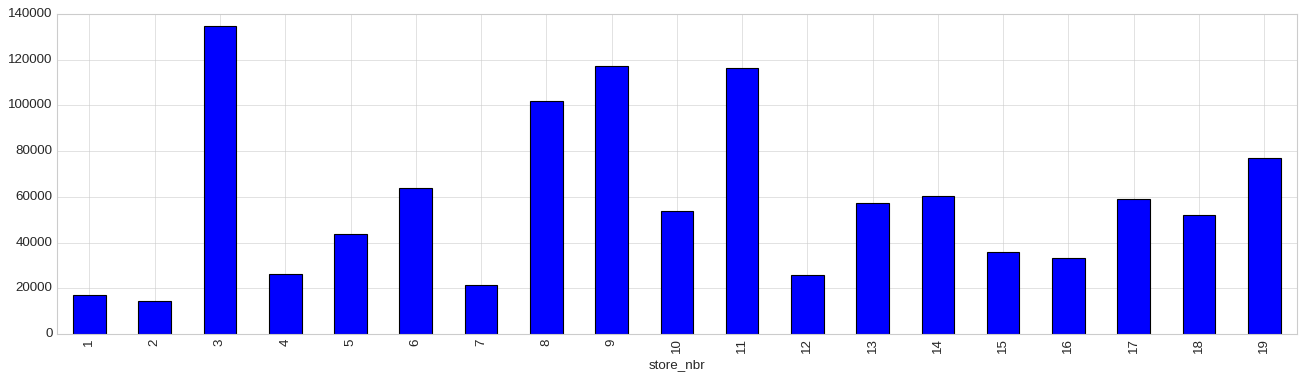

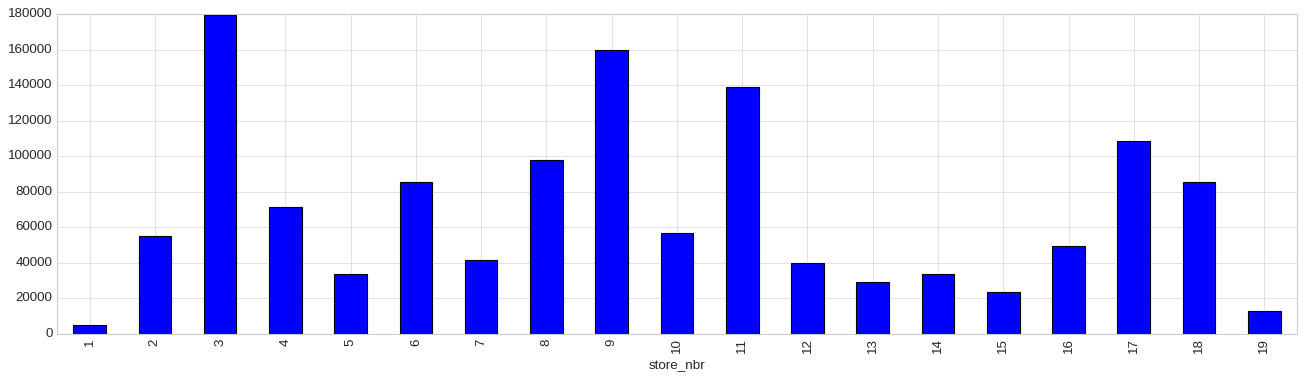

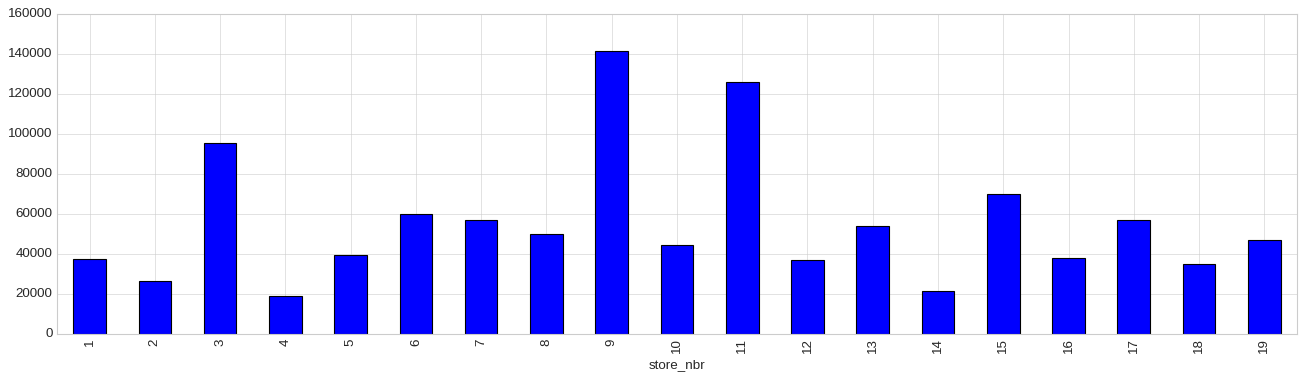

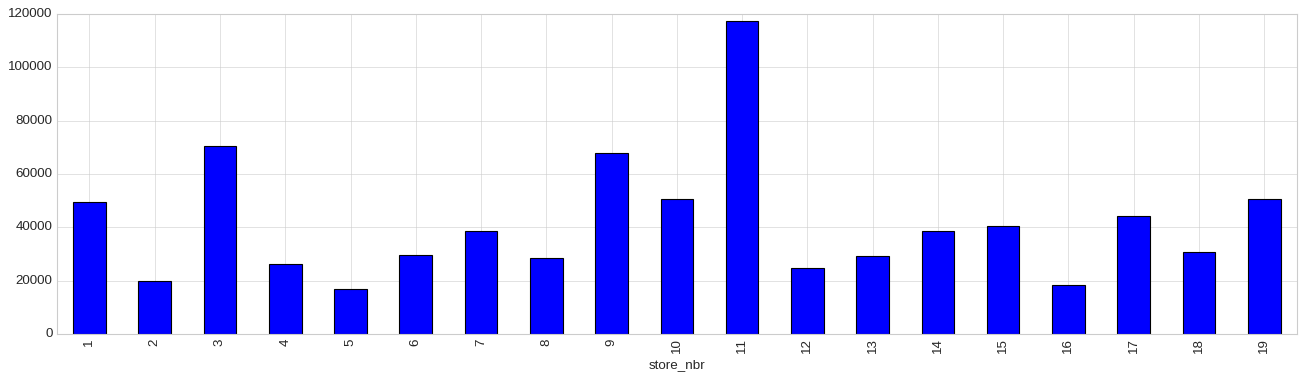

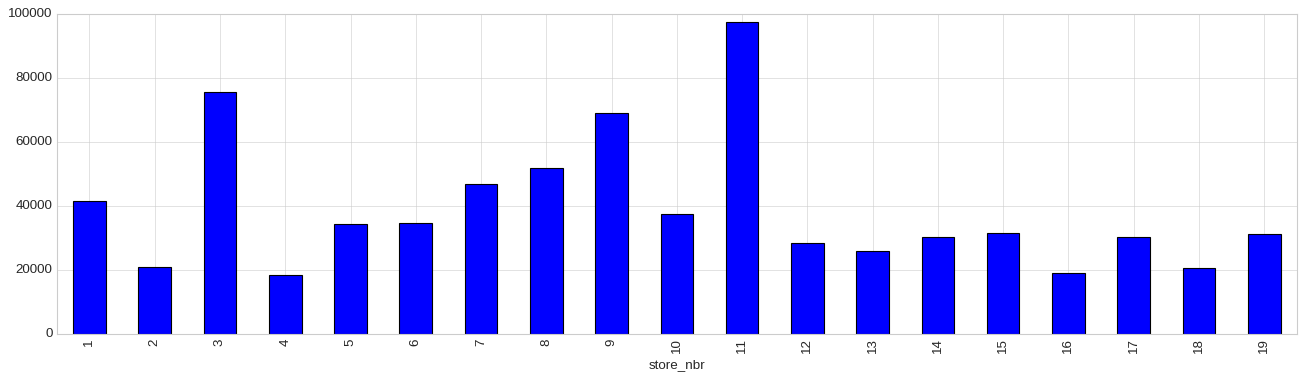

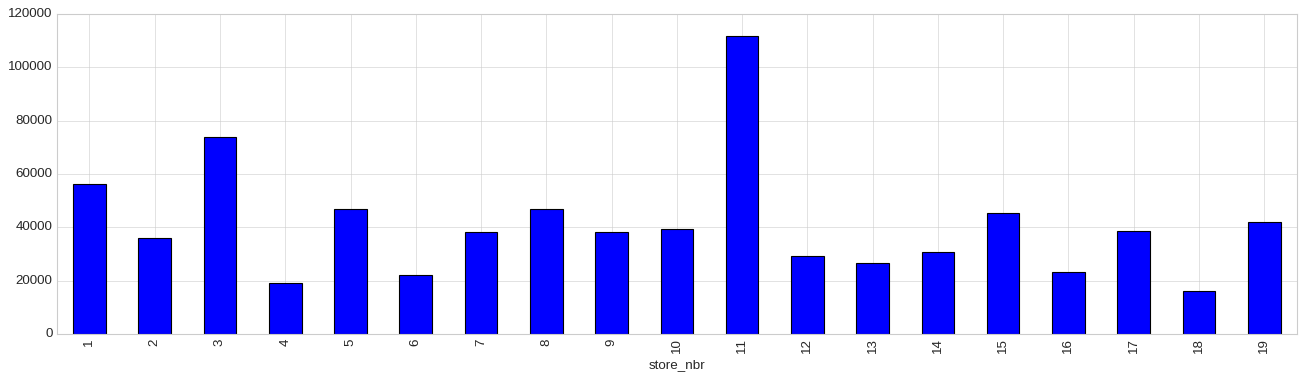

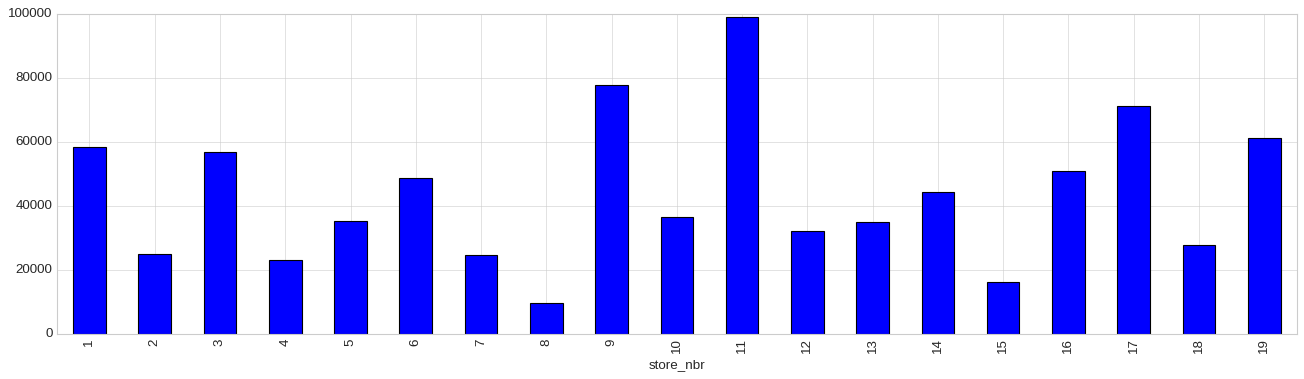

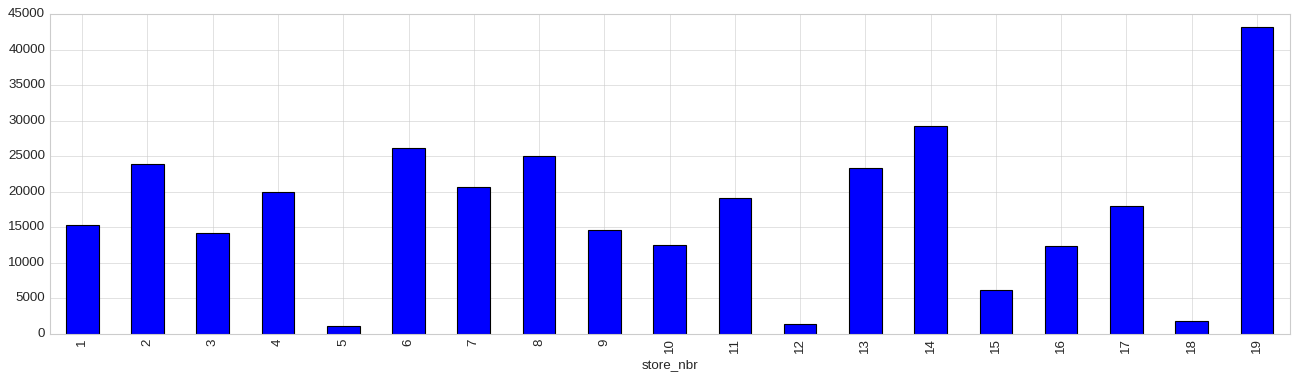

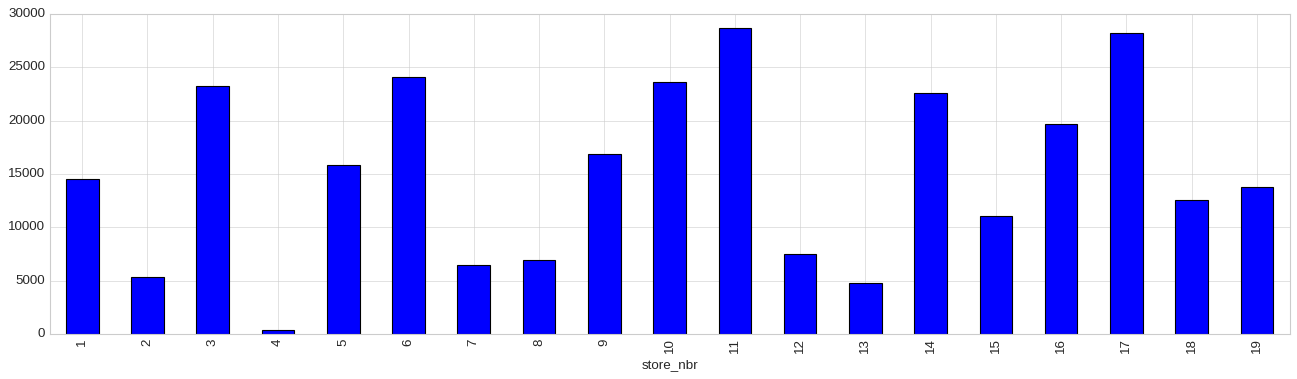

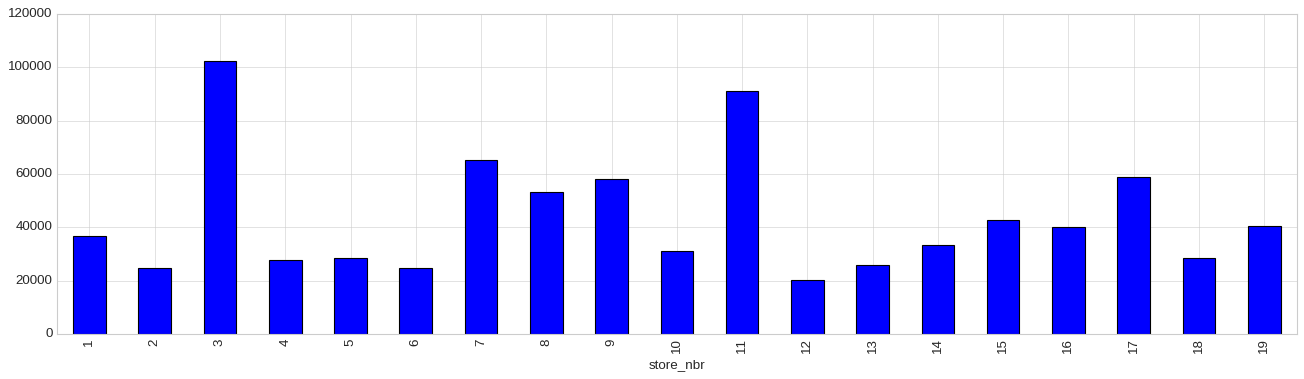

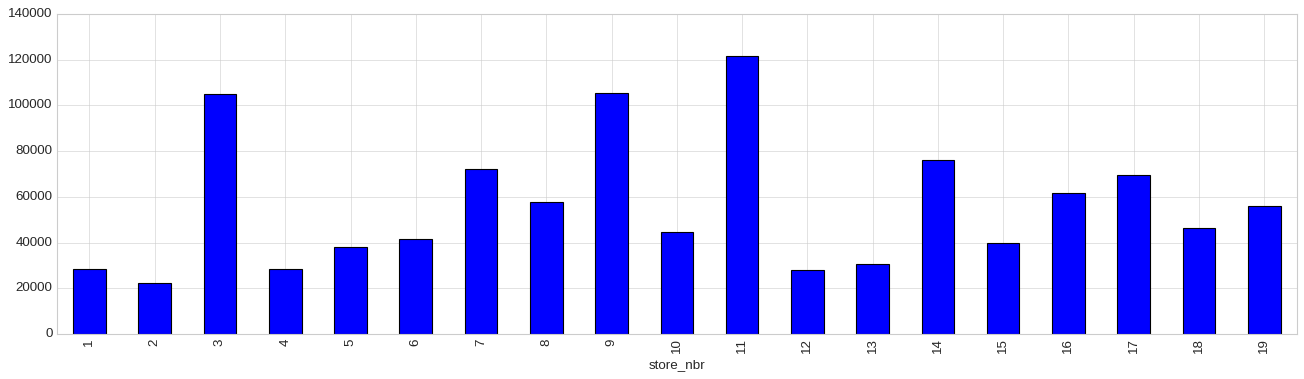

In [91]:
for i in store_results["date"].unique():
  print(i)
  plt.figure(figsize=(20, 5))
  store_results[store_results["date"] ==i]["diff"].plot.bar()

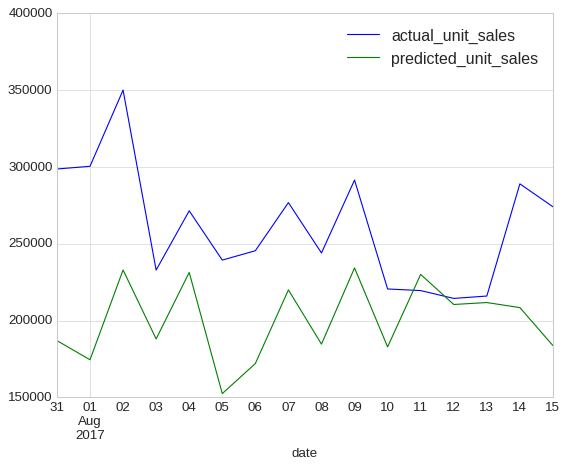

In [92]:
merge_df[merge_df["store_nbr"]==7][["date","actual_unit_sales","predicted_unit_sales"]].groupby("date").sum().plot()

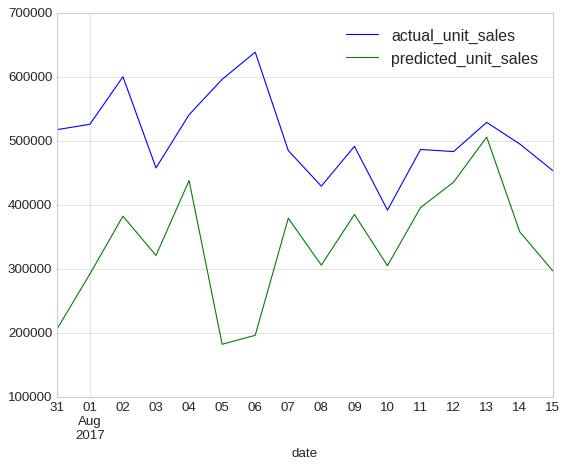

In [93]:
merge_df[merge_df["store_nbr"]==3][["date","actual_unit_sales","predicted_unit_sales"]].groupby("date").sum().plot()

In [ ]:
s_3_class = merge_df[merge_df["store_nbr"]==3][["class","date","actual_unit_sales","predicted_unit_sales"]].groupby(["date","class"]).sum().reset_index()

<Figure size 1600x400 with 0 Axes>

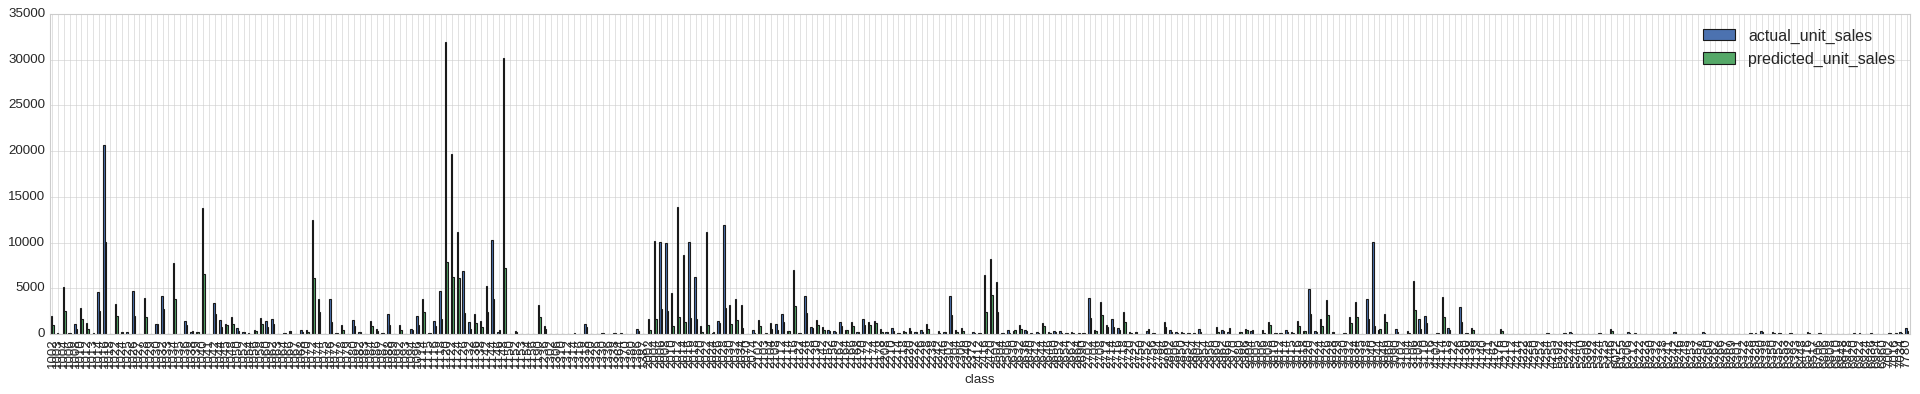

In [ ]:
 plt.figure(figsize=(20, 5))
s_3_class[s_3_class["date"]=="2017-07-31"].plot.bar(x="class", y=["actual_unit_sales","predicted_unit_sales" ],figsize=(30, 5))

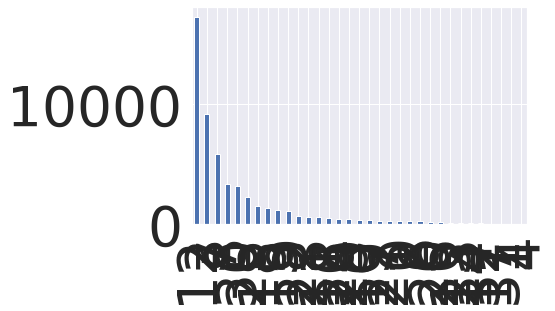

In [ ]:
merge_df[(merge_df["store_nbr"]==7) & (merge_df["date"]=="2017-07-31")]["family"].value_counts().plot.bar()

In [ ]:
merge_df[(merge_df["store_nbr"]==3) & (merge_df["date"]=="2017-07-31")]["family"].value_counts()

12    17408
3      9110
7      5925
8      3362
30     3242
25     2293
18     1566
5      1411
15     1236
9      1122
22      702
28      638
16      594
11      589
24      444
29      405
10      349
19      317
27      309
21      295
0       263
2       245
6       233
20      217
26      187
13      139
23      113
14       74
32       73
31       40
17       19
1        16
4         8
Name: family, dtype: int64

## Model Ensemble

In [94]:
model_outcome_folder = 'drive/MyDrive/favorita/model_outputs'
models_files = [join(model_outcome_folder, f) for f in listdir(model_outcome_folder)]

In [96]:
models_files

['drive/MyDrive/favorita/model_outputs/nn_log_scaled_out_full.csv',
 'drive/MyDrive/favorita/model_outputs/lgbm_log_scaled_out_full.csv',
 'drive/MyDrive/favorita/model_outputs/lgbm_log_scaled_out_fe_model.csv',
 'drive/MyDrive/favorita/model_outputs/nn_log_scaled_out_fe_model.csv']

In [97]:
types = {'store_nbr': 'int8',
                'item_nbr': 'int32',
                'class': 'int8',
                'unit_sales': 'float32',
         'perishable': 'int8'
            }

model_df = pd.read_csv(models_files[2], parse_dates = ['date'], dtype = types, low_memory = True)
model_df.rename(columns={'actual_unit_sales': 'actual', 'predicted_unit_sales': 'pred_m1'}, inplace=True)

model_secondary = pd.read_csv(models_files[3], parse_dates = ['date'], dtype = types, low_memory = True)
model_secondary.rename(columns={'actual_unit_sales': 'actual', 'predicted_unit_sales': 'pred_m2'}, inplace=True)

model_df['pred_m2'] = model_secondary['pred_m2']


In [98]:
weights = model_df["perishable"].values * 0.25 + 1

In [99]:
print('Log',get_error(weights, model_df['actual'].values, model_df["pred_m2"].values))
print('Log', get_error(weights, np.log1p(model_df['actual'].values), np.log1p(model_df["pred_m2"].values)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Log (100.57598623454555, 10.028757960712062, 10.028757960712062, 2.839645926216178, nan)
Log (0.49462513978933603, 0.7032959119668876, 0.7032959119668876, 0.5362865799586755, nan)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [100]:
print('Log',get_error(weights, model_df['actual'].values, model_df["pred_m1"].values))
print('Log', get_error(weights, np.log1p(model_df['actual'].values), np.log1p(model_df["pred_m1"].values)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Log (77.23395523638226, 8.78828511351232, 8.78828511351232, 2.457312834388106, nan)
Log (0.3821504134013215, 0.618183155222885, 0.618183155222885, 0.46539578098438134, nan)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [101]:
# model_df["pred_final"] = model_df[["pred_m1", "pred_m2"]].max(axis=1)
model_df["pred_final"] = 0.8*model_df["pred_m1"] + 0.2*model_df["pred_m2"]

In [102]:
print('Log',get_error(weights, model_df['actual'].values, model_df["pred_final"].values))
print('Log', get_error(weights, np.log1p(model_df['actual'].values), np.log1p(model_df["pred_final"].values)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Log (79.6171524954877, 8.922844417308177, 8.922844417308177, 2.500176527606513, inf)
Log (0.3898575025995123, 0.6243857001882028, 0.6243857001882028, 0.4773033801971414, inf)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
